# Paths

In [18]:
import shutil

folder_path = "Chinese Babycry"
output_zip = "Chinese Babycry"

# This will create myfolder.zip
#shutil.make_archive(output_zip, 'zip', folder_path)


In [19]:
f0_conf_wave_train_dir = "Chinese Babycry/Reverb_Train_Split_80_f0_wave_conf_arrays"
f0_conf_wave_test_dir = "Chinese Babycry/Reverb_Test_Split_20_f0_wave_conf_arrays"
audio_train_dir = "Chinese Babycry/Train_Split_80"
audio_test_dir = "Chinese Babycry/Test_Split_20"


f0_conf_wave_train_dir = "Chinese Babycry/Reverb_Train_Split_80_f0_wave_conf_arrays"
f0_conf_wave_test_dir = "Chinese Babycry/Reverb_Test_Split_20_f0_wave_conf_arrays"
audio_train_dir = "Chinese Babycry/Train_Split_80"
audio_test_dir = "Chinese Babycry/Test_Split_20"

# Loading all F0 wave cof in big train test and labels dataset and encode labels

It already extracted by Crepe and resized to median but even if it is not resized it is gonna be in this code

## How I extracted F0

In [3]:
# # -*- coding: utf-8 -*-
# import os
# import sys
# import glob
# import csv
# import numpy as np
# import soundfile as sf
# import librosa
# import crepe
# from pathlib import Path
# from tqdm.auto import tqdm

# # --------------------------
# # CONFIG
# # --------------------------
# PATH_TRAIN = r"H:\Crynostics\Datas\Chinese Baby_Crying940\Reverb_Test_Split_20"  # root with class subfolders
# OUT_ROOT   = r"H:\Crynostics\Datas\Chinese Baby_Crying940\Reverb_Test_Split_20_f0_wave_conf_arrays"            # where to save arrays
# TARGET_SR  = 16000
# STEP_SAMPLES = 200          # CREPE hop in samples @ 16k (200 -> 12.5 ms)
# CREPE_CAPACITY = "medium"   # "tiny"|"small"|"medium"|"large"|"full"
# USE_VITERBI = True
# ALLOWED_EXT = (".wav", ".flac", ".ogg")  # extend if needed

# # --------------------------
# # HELPERS
# # --------------------------
# def load_mono_and_resample(path: str, target_sr: int) -> tuple[np.ndarray, int]:
#     """Load audio as mono float32 and resample to target_sr if needed."""
#     y, sr = sf.read(path, always_2d=False)
#     if isinstance(y, np.ndarray) and y.ndim > 1:
#         y = y.mean(axis=1)
#     y = y.astype(np.float32, copy=False)
#     if sr != target_sr:
#         y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
#         sr = target_sr
#     return y, sr

# def f0_crepe(y16: np.ndarray, sr16: int, step_samples: int, capacity: str, viterbi: bool):
#     """Run CREPE F0; returns (time_s, f0_hz, confidence)."""
#     time_s, f0_hz, conf, _ = crepe.predict(
#         y16, sr16,
#         step_size=step_samples,
#         viterbi=viterbi,
#         model_capacity=capacity,
#         verbose=0
#     )
#     return time_s.astype(np.float32), f0_hz.astype(np.float32), conf.astype(np.float32)

# def waveform_on_grid(y16: np.ndarray, sr16: int, t_grid_s: np.ndarray) -> np.ndarray:
#     """Sample waveform at exact CREPE frame centers (nearest-neighbor)."""
#     idx = np.clip((t_grid_s * sr16).astype(int), 0, len(y16) - 1)
#     return y16[idx].astype(np.float32)

# def make_out_path(out_root: str, class_label: str, wav_path: str) -> str:
#     """Create class subdir and build .npy filename from input wav stem."""
#     stem = Path(wav_path).stem
#     class_dir = Path(out_root) / class_label
#     class_dir.mkdir(parents=True, exist_ok=True)
#     return str(class_dir / f"{stem}_f0_wave_conf.npy")

# # --------------------------
# # SCAN FILES
# # --------------------------
# def list_audio_files(root: str) -> list[tuple[str, str]]:
#     """
#     Return a list of (wav_path, class_label), assuming structure:
#       root/<class_label>/*.(wav/flac/ogg)
#     """
#     out = []
#     for class_dir in sorted(Path(root).glob("*")):
#         if not class_dir.is_dir():
#             continue
#         label = class_dir.name
#         for ext in ALLOWED_EXT:
#             for p in class_dir.rglob(f"*{ext}"):
#                 out.append((str(p), label))
#     return out

# # --------------------------
# # MAIN
# # --------------------------
# def main():
#     files = list_audio_files(PATH_TRAIN)
#     if not files:
#         print(f"No audio files found under: {PATH_TRAIN}")
#         sys.exit(1)

#     Path(OUT_ROOT).mkdir(parents=True, exist_ok=True)
#     manifest_path = Path(OUT_ROOT) / "manifest.csv"

#     # Write CSV header
#     with open(manifest_path, "w", newline="", encoding="utf-8") as fcsv:
#         w = csv.writer(fcsv)
#         w.writerow([
#             "input_path", "class_label", "array_path",
#             "n_frames", "duration_s", "sr", "step_samples"
#         ])

#     with tqdm(total=len(files), desc="Processing files", unit="file") as pbar:
#         for wav_path, label in files:
#             try:
#                 # 1) Load + resample to 16 kHz mono
#                 y16, sr16 = load_mono_and_resample(wav_path, TARGET_SR)
#                 duration_s = len(y16) / float(sr16)

#                 # 2) CREPE F0
#                 time_s, f0_hz, conf = f0_crepe(
#                     y16, sr16,
#                     step_samples=STEP_SAMPLES,
#                     capacity=CREPE_CAPACITY,
#                     viterbi=USE_VITERBI
#                 )

#                 # 3) Waveform sampled on the same grid
#                 wave_grid = waveform_on_grid(y16, sr16, time_s)

#                 # 4) Stack rows: [waveform; f0; confidence] -> (3, T)
#                 arr = np.vstack([wave_grid, f0_hz, conf]).astype(np.float32)

#                 # 5) Save
#                 out_npy = make_out_path(OUT_ROOT, label, wav_path)
#                 np.save(out_npy, arr)

#                 # 6) Append manifest
#                 with open(manifest_path, "a", newline="", encoding="utf-8") as fcsv:
#                     w = csv.writer(fcsv)
#                     w.writerow([
#                         wav_path, label, out_npy,
#                         arr.shape[1], f"{duration_s:.6f}", sr16, STEP_SAMPLES
#                     ])

#             except Exception as e:
#                 # Log failures but keep going
#                 err_line = f"[ERROR] {wav_path} ({label}): {e}"
#                 print(err_line)

#             pbar.update(1)

#     print("\nDone.")
#     print(f"Saved arrays under: {OUT_ROOT}")
#     print(f"Manifest: {manifest_path}")

# if __name__ == "__main__":
#     main()


# How I loaded f0 wave confidence

In [20]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

def load_npy_data(base_dir):
    feature_list = []
    label_list = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.npy'):
                file_path = os.path.join(root, file)
                try:
                    array = np.load(file_path)  # shape (3, X)
                    feature_list.append(array)
                    label_list.append(os.path.basename(root))
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
    features_df = pd.DataFrame({'features': feature_list})
    labels_df = pd.DataFrame({'folder': label_list})
    return features_df, labels_df


# Load test STFT data
test_F0_df, test_label = load_npy_data(f0_conf_wave_test_dir)

# Load train MFCC data
train_F0_df, train_label = load_npy_data(f0_conf_wave_train_dir)

train_F0_df.reset_index(drop=True, inplace=True)
test_F0_df.reset_index(drop=True, inplace=True)

# Optional: check number of samples loaded
print(f"Test F0 files: {len(test_F0_df)}")
print(f"Train F0 files: {len(train_F0_df)}")

# Compute lengths of each array (X dimension)
lengths_test = test_F0_df['features'].apply(lambda x: x.shape[1])
lengths_train = train_F0_df['features'].apply(lambda x: x.shape[1])

median_length_test = int(np.median(lengths_test))
median_length_train = int(np.median(lengths_train))

print("Median length test:", median_length_test)
print("Median length train:", median_length_train)


def resize_sequence(seq, target_len):
    """
    Resize a (3, X) sequence along the X axis to target_len.
    """
    seq = np.array(seq)
    rows, current_len = seq.shape

    if current_len == target_len:
        return seq
    else:
        resized = np.zeros((rows, target_len))
        original_idx = np.linspace(0, 1, current_len)
        target_idx = np.linspace(0, 1, target_len)
        for i in range(rows):
            f = interp1d(original_idx, seq[i, :], kind='linear')
            resized[i, :] = f(target_idx)
        return resized


# Usage example: resize all sequences in a DataFrame column
target_length = median_length_train  # or any fixed length
test_F0_df['resized_features'] = test_F0_df['features'].apply(lambda x: resize_sequence(x, target_length))
train_F0_df['resized_features'] = train_F0_df['features'].apply(lambda x: resize_sequence(x, target_length))

print("resized version test: ", test_F0_df['resized_features'][10].shape,
      "old version test: ", test_F0_df['features'][10].shape)

print("resized version train: ", train_F0_df['resized_features'][10].shape,
      "old version train: ", train_F0_df['features'][10].shape)


Test F0 files: 184
Train F0 files: 734
Median length test: 107
Median length train: 108
resized version test:  (3, 108) old version test:  (3, 135)
resized version train:  (3, 108) old version train:  (3, 126)


# Integrate all Feature

# MFCC

In [21]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import librosa

# -----------------------------
# Params
# -----------------------------
SR = 16000           # target sample rate
FRAME_MS = 30.0      # window length (ms) = frame size
HOP_MS = 15.0        # hop length (ms). Use 30.0 if you want no overlap
N_MFCC = 20          # MFCC coefficients (common: 13 or 20)
AUDIO_EXTS = {".wav", ".mp3", ".flac", ".ogg", ".m4a"}

WIN_LENGTH = int(round(SR * FRAME_MS / 1000.0))
HOP_LENGTH = int(round(SR * HOP_MS   / 1000.0))
N_FFT = 1
while N_FFT < WIN_LENGTH:  # next power of two >= win_length (librosa-friendly)
    N_FFT <<= 1

def is_audio_file(path):
    return os.path.splitext(path)[1].lower() in AUDIO_EXTS

def compute_mfcc(file_path, sr=SR, n_mfcc=N_MFCC,
                 n_fft=N_FFT, win_length=WIN_LENGTH, hop_length=HOP_LENGTH):
    """
    Returns MFCC array of shape (n_mfcc, T).
    """
    y, _ = librosa.load(file_path, sr=sr, mono=True)
    # Use center=True (default) for better coverage at edges
    mfcc = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=n_mfcc,
        n_fft=n_fft, hop_length=hop_length, win_length=win_length,
        center=True
    )
    return mfcc  # (n_mfcc, T)

def load_mfcc_dataset(root_dir):
    """
    Walks class-labeled subfolders under root_dir, computes MFCC for each audio.
    Returns a DataFrame with columns: ['mfcc', 'label', 'path'].
    """
    feats, labels, paths = [], [], []
    for class_dir in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_dir)
        if not os.path.isdir(class_path):
            continue
        for fname in sorted(os.listdir(class_path)):
            fpath = os.path.join(class_path, fname)
            if not os.path.isfile(fpath) or not is_audio_file(fpath):
                continue
            try:
                mfcc = compute_mfcc(fpath)
                feats.append(mfcc)
                labels.append(class_dir)
                paths.append(fpath)
            except Exception as e:
                print(f"[WARN] Skipped {fpath}: {e}")
    df = pd.DataFrame({"mfcc": feats, "label": labels, "path": paths})
    return df

def resize_time_axis(feat_2d, target_len):
    """
    Resize a (C, T) feature matrix along time axis to target_len using linear interp.
    C = channels/features (e.g., n_mfcc), T = time frames.
    """
    feat_2d = np.asarray(feat_2d)
    C, T = feat_2d.shape
    if T == target_len:
        return feat_2d

    # Build interpolation index
    orig_idx = np.linspace(0.0, 1.0, num=T, endpoint=True)
    tgt_idx  = np.linspace(0.0, 1.0, num=target_len, endpoint=True)

    out = np.empty((C, target_len), dtype=np.float32)
    for c in range(C):
        f = interp1d(orig_idx, feat_2d[c, :], kind="linear", assume_sorted=True)
        out[c, :] = f(tgt_idx)
    return out

# -----------------------------
# Paths (update these)
# -----------------------------
train_audio_root = r".../Train"  # each subfolder is a class
test_audio_root  = r".../Test"   # each subfolder is a class

# -----------------------------
# Load MFCCs
# -----------------------------
train_df = load_mfcc_dataset(audio_train_dir)
test_df  = load_mfcc_dataset(audio_test_dir)

# Optional: sanity check
print(f"Train audio files: {len(train_df)}")
print(f"Test  audio files: {len(test_df)}")

# -----------------------------
# Determine target length (median frames of TRAIN)
# -----------------------------
train_lengths = train_df["mfcc"].apply(lambda m: m.shape[1])
test_lengths  = test_df["mfcc"].apply(lambda m: m.shape[1])

target_len = int(np.median(train_lengths))
print(f"Median time frames (train): {target_len} "
      f"(win={WIN_LENGTH} samples, hop={HOP_LENGTH} samples @ {SR} Hz)")

# -----------------------------
# Resize MFCCs along time axis
# -----------------------------
train_df["mfcc_resized"] = train_df["mfcc"].apply(lambda M: resize_time_axis(M, target_len))
test_df["mfcc_resized"]  = test_df["mfcc"].apply(lambda M: resize_time_axis(M, target_len))

# Example: shapes before/after
i = min(10, len(train_df)-1)
j = min(10, len(test_df)-1)
print("Train sample shapes:", train_df.loc[i, "mfcc"].shape, "->", train_df.loc[i, "mfcc_resized"].shape)
print("Test  sample shapes:", test_df.loc[j, "mfcc"].shape, "->", test_df.loc[j, "mfcc_resized"].shape)

# -----------------------------
# (Optional) Pack arrays for modeling
# X_train: (N, n_mfcc, target_len), y_train: labels
# -----------------------------
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train_df["label"].values)
y_test  = le.transform(test_df["label"].values) if set(test_df["label"]) <= set(le.classes_) else \
          le.fit_transform(test_df["label"].values)  # fallback if classes differ

X_train_mfcc = np.stack(train_df["mfcc_resized"].values, axis=0)
X_test_mfcc  = np.stack(test_df["mfcc_resized"].values, axis=0)

print("X_train:", X_train_mfcc.shape, "X_test:", X_test_mfcc.shape)
print("Classes:", list(le.classes_))


Train audio files: 734
Test  audio files: 184
Median time frames (train): 1096 (win=480 samples, hop=240 samples @ 16000 Hz)
Train sample shapes: (20, 1644) -> (20, 1096)
Test  sample shapes: (20, 1201) -> (20, 1096)
X_train: (734, 20, 1096) X_test: (184, 20, 1096)
Classes: ['awake', 'diaper', 'hug', 'hungry', 'sleepy', 'uncomfortable']


# STFT

In [22]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import librosa

# -----------------------------
# Params
# -----------------------------
SR = 16000           # target sample rate
FRAME_MS = 30.0      # window length (ms) = frame size
HOP_MS = 15.0        # hop length (ms). Use 30.0 if you want no overlap
AUDIO_EXTS = {".wav", ".mp3", ".flac", ".ogg", ".m4a"}

# STFT scaling options
POWER = 1.0          # 1.0 = magnitude, 2.0 = power
TO_DB = True         # convert to dB (log scale) for nicer dynamics
DB_REF = 1.0         # reference for dB conversion (librosa default is max if ref=np.max)

WIN_LENGTH = int(round(SR * FRAME_MS / 1000.0))
HOP_LENGTH = int(round(SR * HOP_MS   / 1000.0))
N_FFT = 1
while N_FFT < WIN_LENGTH:  # next power of two >= win_length (librosa-friendly)
    N_FFT <<= 1

def is_audio_file(path):
    return os.path.splitext(path)[1].lower() in AUDIO_EXTS

def compute_stft(file_path,
                 sr=SR, n_fft=N_FFT, win_length=WIN_LENGTH, hop_length=HOP_LENGTH,
                 power=POWER, to_db=TO_DB, db_ref=DB_REF):
    """
    Returns STFT feature of shape (freq_bins, T).
    By default: |STFT|^POWER, optionally converted to dB.
    """
    y, _ = librosa.load(file_path, sr=sr, mono=True)
    S_complex = librosa.stft(
        y,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window='hann',
        center=True
    )
    S_mag = np.abs(S_complex) ** power  # (n_fft//2+1, T)

    if to_db:
        # Avoid -inf by using a small floor; librosa handles this internally
        S_feat = librosa.amplitude_to_db(S_mag, ref=db_ref) if power == 1.0 \
                 else librosa.power_to_db(S_mag, ref=db_ref)
    else:
        S_feat = S_mag

    return S_feat.astype(np.float32)

def load_stft_dataset(root_dir):
    """
    Walks class-labeled subfolders under root_dir, computes STFT for each audio.
    Returns a DataFrame with columns: ['stft', 'label', 'path'].
    """
    feats, labels, paths = [], [], []
    for class_dir in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_dir)
        if not os.path.isdir(class_path):
            continue
        for fname in sorted(os.listdir(class_path)):
            fpath = os.path.join(class_path, fname)
            if not os.path.isfile(fpath) or not is_audio_file(fpath):
                continue
            try:
                stft = compute_stft(fpath)
                feats.append(stft)           # (F, T)
                labels.append(class_dir)
                paths.append(fpath)
            except Exception as e:
                print(f"[WARN] Skipped {fpath}: {e}")
    return pd.DataFrame({"stft": feats, "label": labels, "path": paths})

def resize_time_axis(feat_2d, target_len):
    """
    Resize a (C, T) feature matrix along the time axis to target_len using linear interpolation.
    C = channels/frequency bins, T = time frames.
    """
    feat_2d = np.asarray(feat_2d)
    C, T = feat_2d.shape
    if T == target_len:
        return feat_2d

    orig_idx = np.linspace(0.0, 1.0, num=T, endpoint=True)
    tgt_idx  = np.linspace(0.0, 1.0, num=target_len, endpoint=True)

    out = np.empty((C, target_len), dtype=np.float32)
    for c in range(C):
        f = interp1d(orig_idx, feat_2d[c, :], kind="linear", assume_sorted=True)
        out[c, :] = f(tgt_idx)
    return out

# -----------------------------
# Paths (update these)
# -----------------------------
train_audio_root = r".../Train"  # each subfolder is a class
test_audio_root  = r".../Test"   # each subfolder is a class

# -----------------------------
# Load STFTs
# -----------------------------
train_df = load_stft_dataset(audio_train_dir)
test_df  = load_stft_dataset(audio_test_dir)

print(f"Train audio files: {len(train_df)}")
print(f"Test  audio files: {len(test_df)}")

# -----------------------------
# Determine target length (median frames of TRAIN)
# -----------------------------
train_lengths = train_df["stft"].apply(lambda m: m.shape[1])
test_lengths  = test_df["stft"].apply(lambda m: m.shape[1])

target_len = int(np.median(train_lengths))
print(f"Median time frames (train): {target_len} "
      f"(win={WIN_LENGTH} samples, hop={HOP_LENGTH} samples @ {SR} Hz, n_fft={N_FFT})")

# -----------------------------
# Resize STFTs along time axis
# -----------------------------
train_df["stft_resized"] = train_df["stft"].apply(lambda M: resize_time_axis(M, target_len))
test_df["stft_resized"]  = test_df["stft"].apply(lambda M: resize_time_axis(M, target_len))

# Example: shapes before/after
i = min(10, len(train_df)-1)
j = min(10, len(test_df)-1)
print("Train sample shapes:", train_df.loc[i, "stft"].shape, "->", train_df.loc[i, "stft_resized"].shape)
print("Test  sample shapes:", test_df.loc[j, "stft"].shape, "->", test_df.loc[j, "stft_resized"].shape)

# -----------------------------
# (Optional) Pack arrays for modeling
# X_train: (N, F, target_len), y_train: labels
# -----------------------------
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(pd.concat([train_df["label"], test_df["label"]], axis=0))

y_train_stft = le.transform(train_df["label"].values)
y_test  = le.transform(test_df["label"].values)

X_train_stft = np.stack(train_df["stft_resized"].values, axis=0)  # (N, F, T)
X_test_stft  = np.stack(test_df["stft_resized"].values, axis=0)

print("X_train:", X_train_stft.shape, "X_test:", X_test_stft.shape)
print("Classes:", list(le.classes_))


Train audio files: 734
Test  audio files: 184
Median time frames (train): 1096 (win=480 samples, hop=240 samples @ 16000 Hz, n_fft=512)
Train sample shapes: (257, 1644) -> (257, 1096)
Test  sample shapes: (257, 1201) -> (257, 1096)
X_train: (734, 257, 1096) X_test: (184, 257, 1096)
Classes: ['awake', 'diaper', 'hug', 'hungry', 'sleepy', 'uncomfortable']


# Integration

In [23]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd

# =========================
# Helpers
# =========================
def _pick_col(df, candidates=("stft_resized","mfcc_resized","resized_features","features","stft","mfcc")):
    for c in candidates:
        if isinstance(df, pd.DataFrame) and c in df.columns:
            return c
    raise KeyError(f"No feature column found. Tried: {candidates}")

def _len_source(source):
    if isinstance(source, pd.DataFrame):
        return len(source)
    return source.shape[0]  # assume ndarray (N, ...)

def _get_sample_feat(source, i):
    """
    Returns a (C, T) float32 array for sample i from either:
      - DataFrame with a feature column, or
      - NumPy array shaped (N, C, T)
    """
    if isinstance(source, pd.DataFrame):
        col = _pick_col(source)
        arr = source[col].iloc[i]
    else:  # ndarray
        arr = source[i]
    arr = np.asarray(arr)
    if arr.ndim != 2:
        raise ValueError(f"Expected per-sample 2D (C,T); got {arr.shape}")
    return arr.astype(np.float32)

def _resize_time_axis(feat_2d, target_len):
    """Resize (C, T) -> (C, target_len) by linear interpolation over time axis."""
    C, T = feat_2d.shape
    if T == target_len:
        return feat_2d
    orig = np.linspace(0.0, 1.0, T, endpoint=True)
    tgt  = np.linspace(0.0, 1.0, target_len, endpoint=True)
    out = np.empty((C, target_len), dtype=np.float32)
    for c in range(C):
        f = interp1d(orig, feat_2d[c, :], kind="linear", assume_sorted=True)
        out[c, :] = f(tgt)
    return out

def _combine_three_modalities(stft_feat, mfcc_feat, f0_feat, target_len):
    """
    All inputs are (C, T). They are resized to the same target_len and concatenated on C.
    Returns (T, C_total).
    """
    stft_feat = _resize_time_axis(stft_feat, target_len)
    mfcc_feat = _resize_time_axis(mfcc_feat, target_len)
    f0_feat   = _resize_time_axis(f0_feat,   target_len)
    CxT = np.concatenate([stft_feat, mfcc_feat, f0_feat], axis=0)  # (C_total, T) ################################################################ without f0
    return CxT.T  # (T, C_total)

def _time_lengths(source):
    """Return a list of T (time frames) for all samples in source."""
    n = _len_source(source)
    Ts = []
    for i in range(n):
        C, T = _get_sample_feat(source, i).shape
        Ts.append(T)
    return np.array(Ts, dtype=int)

def _channels_first(source):
    """Return channel dimension (C) of the first sample."""
    C, T = _get_sample_feat(source, 0).shape
    return C

def _summarize(name, source):
    """
    Print N, example shape, channels, and time stats (min/median/max) for a dataset.
    """
    n = _len_source(source)
    C0 = _channels_first(source)
    Ts = _time_lengths(source)
    print(f"{name}: N={n}, example (C,T)=({C0},{Ts[0]})")
    print(f"  Channels (C) ~ {C0} (assumed constant)")
    print(f"  Time frames (T): min={Ts.min()}, median={int(np.median(Ts))}, max={Ts.max()}")

def _stack_combined(stft_src, mfcc_src, f0_src, target_len=None):
    """
    Build (N, T, F) by concatenating STFT, MFCC, F0 along features for each sample.
    Ensures uniform T across samples by using:
      - provided target_len, or
      - median T of STFT set if target_len is None.
    """
    n = min(_len_source(stft_src), _len_source(mfcc_src), _len_source(f0_src))
    if n == 0:
        raise ValueError("No samples to combine.")

    # Decide a uniform target length
    if target_len is None:
        target_len = int(np.median(_time_lengths(stft_src)))  # use STFT's median frames

    combined = []
    for i in range(n):
        stft_i = _get_sample_feat(stft_src, i)   # (F_stft, T_s)
        mfcc_i = _get_sample_feat(mfcc_src, i)   # (C_mfcc, T_m)
        f0_i   = _get_sample_feat(f0_src, i)     # (3, T_f0)
        combined_i = _combine_three_modalities(stft_i, mfcc_i, f0_i, target_len=target_len)  # (T, F_total)
        combined.append(combined_i)
    return np.stack(combined, axis=0)  # (N, T, F)

# =========================================================
# Your inputs (must already be in memory):
#   train_F0_df, test_F0_df           -> DataFrames with (3, T) per sample in a feature col
#   X_train_mfcc, X_test_mfcc         -> DataFrames or arrays with (C_mfcc, T)
#   X_train_stft, X_test_stft         -> DataFrames or arrays with (F_stft, T)
# =========================================================

# -----------------------------
# PRE-COMBINE SHAPE SUMMARIES
# -----------------------------
print("=== PRE-COMBINE SUMMARY: TRAIN ===")
_summarize("STFT_train", X_train_stft)
_summarize("MFCC_train", X_train_mfcc)
_summarize("F0_train",   train_F0_df)

print("\n=== PRE-COMBINE SUMMARY: TEST ===")
_summarize("STFT_test", X_test_stft)
_summarize("MFCC_test", X_test_mfcc)
_summarize("F0_test",   test_F0_df)

# -----------------------------
# CHOOSE UNIFORM TARGET LENGTH
# Use train STFT median for both train & test (keeps shapes consistent for modeling)
# -----------------------------
target_len_train = int(np.median(_time_lengths(X_train_stft)))
target_len_test  = target_len_train  # enforce same T across splits

print(f"\nTarget time length (frames): train={target_len_train}, test={target_len_test}")

# -----------------------------
# COMBINE (STFT + MFCC + F0) -> (N, T, F)
# -----------------------------
Train_combined = _stack_combined(X_train_stft, X_train_mfcc, train_F0_df, target_len=target_len_train)
Test_combined  = _stack_combined(X_test_stft,  X_test_mfcc,  test_F0_df,  target_len=target_len_test)

# -----------------------------
# POST-COMBINE SHAPES
# -----------------------------
print("\n=== POST-COMBINE SHAPES ===")
print("Train_combined (N, T, F):", Train_combined.shape)
print("Test_combined  (N, T, F):", Test_combined.shape)

# Optional peek at per-sample shapes
if Train_combined.size:
    print("One train sample (T,F):", Train_combined[0].shape)
if Test_combined.size:
    print("One test  sample (T,F):", Test_combined[0].shape)


=== PRE-COMBINE SUMMARY: TRAIN ===
STFT_train: N=734, example (C,T)=(257,1096)
  Channels (C) ~ 257 (assumed constant)
  Time frames (T): min=1096, median=1096, max=1096
MFCC_train: N=734, example (C,T)=(20,1096)
  Channels (C) ~ 20 (assumed constant)
  Time frames (T): min=1096, median=1096, max=1096
F0_train: N=734, example (C,T)=(3,108)
  Channels (C) ~ 3 (assumed constant)
  Time frames (T): min=108, median=108, max=108

=== PRE-COMBINE SUMMARY: TEST ===
STFT_test: N=184, example (C,T)=(257,1096)
  Channels (C) ~ 257 (assumed constant)
  Time frames (T): min=1096, median=1096, max=1096
MFCC_test: N=184, example (C,T)=(20,1096)
  Channels (C) ~ 20 (assumed constant)
  Time frames (T): min=1096, median=1096, max=1096
F0_test: N=184, example (C,T)=(3,108)
  Channels (C) ~ 3 (assumed constant)
  Time frames (T): min=108, median=108, max=108

Target time length (frames): train=1096, test=1096

=== POST-COMBINE SHAPES ===
Train_combined (N, T, F): (734, 1096, 277)
Test_combined  (N, T, F

# Combined feature module for Feature extration modular

In [24]:
# -*- coding: utf-8 -*-
from __future__ import annotations
import os
from pathlib import Path
from typing import Iterable, List, Tuple, Dict, Optional, Literal

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import librosa

# -----------------------------
# General parameters (can be overridden per call)
# -----------------------------
AUDIO_EXTS = (".wav", ".mp3", ".flac", ".ogg", ".m4a")

def _is_audio(p: Path) -> bool:
    return p.suffix.lower() in AUDIO_EXTS

def _interp_resize_2d(feat_2d: np.ndarray, target_len: int) -> np.ndarray:
    """Resize a (C, T) feature matrix along time axis to target_len using linear interpolation."""
    feat_2d = np.asarray(feat_2d)
    assert feat_2d.ndim == 2, f"Expected 2D (C,T), got {feat_2d.shape}"
    C, T = feat_2d.shape
    if T == target_len:
        return feat_2d.astype(np.float32, copy=False)

    orig_idx = np.linspace(0.0, 1.0, num=T, endpoint=True)
    tgt_idx  = np.linspace(0.0, 1.0, num=target_len, endpoint=True)
    out = np.empty((C, target_len), dtype=np.float32)
    for c in range(C):
        f = interp1d(orig_idx, feat_2d[c, :], kind="linear", assume_sorted=True)
        out[c, :] = f(tgt_idx)
    return out

def _choose_target_len(lengths: Iterable[int], policy: Literal["median","max"]="median") -> int:
    arr = np.array(list(lengths), dtype=int)
    if len(arr) == 0:
        raise ValueError("Cannot choose target length: empty lengths.")
    return int(np.median(arr)) if policy == "median" else int(arr.max())

def _stft(
    y: np.ndarray, sr: int,
    n_fft: int, win_length: int, hop_length: int,
    power: float = 1.0, to_db: bool = True
) -> np.ndarray:
    S_complex = librosa.stft(
        y, n_fft=n_fft, hop_length=hop_length, win_length=win_length,
        window='hann', center=True
    )
    S_mag = np.abs(S_complex) ** power
    if to_db:
        # librosa uses 10*log10 for power and 20*log10 for amplitude internally
        S_db = librosa.power_to_db(S_mag, ref=np.max) if power != 1.0 else librosa.amplitude_to_db(S_mag, ref=np.max)
        return S_db.astype(np.float32)
    return S_mag.astype(np.float32)

def _mfcc(
    y: np.ndarray, sr: int,
    n_mfcc: int, n_fft: int, win_length: int, hop_length: int
) -> np.ndarray:
    M = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=n_mfcc,
        n_fft=n_fft, hop_length=hop_length, win_length=win_length, center=True
    )
    return M.astype(np.float32)

def _load_audio(path: Path, sr: int) -> np.ndarray:
    y, _ = librosa.load(str(path), sr=sr, mono=True)
    return y.astype(np.float32, copy=False)

def _scan_pairs(
    f0_dir: Path, audio_dir: Path
) -> List[Tuple[str, str, Path, Path]]:
    """
    Pair items by (class_folder, file stem). Returns list of tuples:
      (class_label, stem, f0_npy_path, audio_path)

    - f0_dir structure: f0_dir/<class>/*_f0_wave_conf.npy (or any .npy)
    - audio_dir structure: audio_dir/<class>/*.(wav|mp3|...)
    """
    pairs = []
    if not f0_dir.exists():
        raise FileNotFoundError(f"Missing F0 dir: {f0_dir}")
    if not audio_dir.exists():
        raise FileNotFoundError(f"Missing audio dir: {audio_dir}")

    # index audio by (class, stem) -> path
    audio_index: Dict[Tuple[str,str], Path] = {}
    for class_dir in sorted([d for d in audio_dir.iterdir() if d.is_dir()]):
        cls = class_dir.name
        for ap in class_dir.rglob("*"):
            if ap.is_file() and _is_audio(ap):
                audio_index[(cls, ap.stem)] = ap

    # walk f0 npy files and find matching audio
    for class_dir in sorted([d for d in f0_dir.iterdir() if d.is_dir()]):
        cls = class_dir.name
        for npy in class_dir.rglob("*.npy"):
            stem = npy.stem
            # allow suffixes like *_f0_wave_conf; use split at first suffix
            stem_clean = stem.replace("_f0_wave_conf", "")
            key = (cls, stem_clean)
            if key not in audio_index:
                # fallback: try exact stem
                if (cls, stem) in audio_index:
                    key = (cls, stem)
                else:
                    # couldn't match — skip silently but could warn
                    # print(f"[WARN] No matching audio for {npy}")
                    continue
            pairs.append((cls, key[1], npy, audio_index[key]))

    return pairs

def _load_f0_array(npy_path: Path) -> np.ndarray:
    """
    Expect shape (3, T): [wave_on_grid; f0_hz; confidence].
    """
    arr = np.load(str(npy_path))
    arr = np.asarray(arr)
    if arr.ndim != 2 or arr.shape[0] != 3:
        raise ValueError(f"Expected F0 array shape (3, T). Got {arr.shape} from {npy_path}")
    return arr.astype(np.float32)

def build_split(
    f0_dir: str,
    audio_dir: str,
    *,
    sr: int = 16000,
    frame_ms: float = 30.0,
    hop_ms: float = 15.0,
    n_mfcc: int = 20,
    stft_power: float = 1.0,
    stft_to_db: bool = True,
    fixed_target_len: int | None = None,   # <— NEW
    target_len_policy: Literal["median","max"] = "median",
    modalities: Iterable[Literal["stft","mfcc","f0"]] = ("stft","mfcc","f0"),
    strict_triplet: bool = True,
    min_frames: int = 2,                         # <— NEW
) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """
    Build a single split (train OR test).

    Returns:
      X  : (N, T, F) float32 — concatenated [modalities] along feature dim
      y  : (N,) int labels (encoded by alphabetical class order)
      df : manifest with columns [class, stem, f0_path, audio_path, T_stft, T_mfcc, T_f0, T_final]

    Notes:
      - Only items where **all requested modalities** exist are kept.
      - Time axis is resized to a **single target length** chosen from STFT (if present),
        else MFCC, else F0 — according to `target_len_policy`.
    """
    f0_dir = Path(f0_dir)
    audio_dir = Path(audio_dir)
    pairs = _scan_pairs(f0_dir, audio_dir)

    if len(pairs) == 0:
        raise ValueError(f"No (F0, audio) pairs found between {f0_dir} and {audio_dir}.")

    # window sizes
    win_length = int(round(sr * frame_ms / 1000.0))
    hop_length = int(round(sr * hop_ms   / 1000.0))
    # next power of two for n_fft
    n_fft = 1
    while n_fft < win_length:
        n_fft <<= 1

    rows = []
    features_list = []
    labels = []

    # first pass: compute raw modality features + their T lengths
    stft_list, mfcc_list, f0_list = [], [], []
    Ts_stft, Ts_mfcc, Ts_f0 = [], [], []

    kept = 0
    skipped_short = 0
    for cls, stem, f0_path, audio_path in pairs:
        try:
            f0_arr = _load_f0_array(f0_path) if "f0" in modalities else None
            y = _load_audio(audio_path, sr=sr)

            stft_feat = _stft(y, sr, n_fft, win_length, hop_length,
                              power=stft_power, to_db=stft_to_db) if "stft" in modalities else None
            mfcc_feat = _mfcc(y, sr, n_mfcc, n_fft, win_length, hop_length) if "mfcc" in modalities else None

            # record lengths
            Ts_stft.append(stft_feat.shape[1] if stft_feat is not None else -1)
            Ts_mfcc.append(mfcc_feat.shape[1] if mfcc_feat is not None else -1)
            Ts_f0.append(f0_arr.shape[1]   if f0_arr   is not None else -1)

            # skip if any requested modality has too few frames
            if strict_triplet:
                if ("stft" in modalities and (stft_feat is None or stft_feat.shape[1] < min_frames)) \
                or ("mfcc" in modalities and (mfcc_feat is None or mfcc_feat.shape[1] < min_frames)) \
                or ("f0"   in modalities and (f0_arr   is None or f0_arr.shape[1]   < min_frames)):
                    skipped_short += 1
                    continue

            stft_list.append(stft_feat)
            mfcc_list.append(mfcc_feat)
            f0_list.append(f0_arr)
            labels.append(cls)
            rows.append({
                "class": cls, "stem": stem,
                "f0_path": str(f0_path), "audio_path": str(audio_path)
            })
            kept += 1
        except Exception as e:
            # Skip problematic files but keep going
            # print(f"[WARN] Skipped ({cls}/{stem}): {e}")
            continue
            
    if kept == 0:
        raise ValueError(f"After loading, no usable items remained (skipped_short={skipped_short}).")

    if len(labels) == 0:
        raise ValueError("After loading, no usable items remained. Check data.")

    # choose target T from the first available modality in priority order
    def _valid_lengths(L): return [x for x in L if x > 0]
    if fixed_target_len is not None: 
        T_target = int(fixed_target_len)
    elif "stft" in modalities and len(_valid_lengths(Ts_stft)) > 0:
        T_target = _choose_target_len(_valid_lengths(Ts_stft), policy=target_len_policy)
    elif "mfcc" in modalities and len(_valid_lengths(Ts_mfcc)) > 0:
        T_target = _choose_target_len(_valid_lengths(Ts_mfcc), policy=target_len_policy)
    elif "f0" in modalities and len(_valid_lengths(Ts_f0)) > 0:
        T_target = _choose_target_len(_valid_lengths(Ts_f0), policy=target_len_policy)
    else:
        raise ValueError("Could not infer target time length from requested modalities.")

    # second pass: resize and concatenate
    X_list = []
    keep_mask = []
    for stft_feat, mfcc_feat, f0_feat in zip(stft_list, mfcc_list, f0_list):
        if strict_triplet:
            # ensure all requested modalities exist
            if ("stft" in modalities and stft_feat is None) or \
               ("mfcc" in modalities and mfcc_feat is None) or \
               ("f0"   in modalities and f0_feat   is None):
                keep_mask.append(False)
                X_list.append(None)
                continue

        channels = []
        if stft_feat is not None:
            channels.append(_interp_resize_2d(stft_feat, T_target))
        if mfcc_feat is not None:
            channels.append(_interp_resize_2d(mfcc_feat, T_target))
        if f0_feat is not None:
            channels.append(_interp_resize_2d(f0_feat, T_target))  # (3, T)

        if len(channels) == 0:
            keep_mask.append(False)
            X_list.append(None)
            continue

        CxT = np.concatenate(channels, axis=0)     # (C_total, T)
        X_list.append(CxT.T.astype(np.float32))    # (T, C_total)
        keep_mask.append(True)

    # filter by keep_mask
    keep_idx = [i for i, k in enumerate(keep_mask) if k]
    if len(keep_idx) == 0:
        raise ValueError("No samples had all requested modalities (strict_triplet=True).")

    X = np.stack([X_list[i] for i in keep_idx], axis=0)   # (N, T, F)
    y_labels = [labels[i] for i in keep_idx]
    df = pd.DataFrame([rows[i] for i in keep_idx])
    df["T_final"] = T_target
    if "stft" in modalities: df["T_stft"] = [Ts_stft[i] for i in keep_idx]
    if "mfcc" in modalities: df["T_mfcc"] = [Ts_mfcc[i] for i in keep_idx]
    if "f0"   in modalities: df["T_f0"]   = [Ts_f0[i]   for i in keep_idx]

    # encode labels alphabetically (stable & reproducible)
    classes = sorted(pd.unique(df["class"]))
    cls_to_id = {c:i for i,c in enumerate(classes)}
    y = np.array([cls_to_id[c] for c in y_labels], dtype=np.int64)

    return X, y, df.assign(label_id=[cls_to_id[c] for c in y_labels])

def prepare_train_test(
    f0_conf_wave_train_dir: str,
    f0_conf_wave_test_dir: str,
    audio_train_dir: str,
    audio_test_dir: str,
    *,
    sr: int = 16000,
    frame_ms: float = 30.0,
    hop_ms: float = 15.0,
    n_mfcc: int = 20,
    stft_power: float = 1.0,
    stft_to_db: bool = True,
    target_len_policy: Literal["median","max"] = "median",
    modalities: Iterable[Literal["stft","mfcc","f0"]] = ("stft","mfcc","f0"),
    strict_triplet: bool = True,
    fixed_target_len: int | None = None,   # <— NEW
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, Dict[int,str], pd.DataFrame, pd.DataFrame]:
    """
    Convenience wrapper to build train & test with identical settings.

    Returns:
      X_train, y_train, X_test, y_test,
      id_to_class (dict), train_manifest (df), test_manifest (df)
    """
    X_train, y_train, df_train = build_split(
        f0_conf_wave_train_dir, audio_train_dir,
        sr=sr, frame_ms=frame_ms, hop_ms=hop_ms, n_mfcc=n_mfcc,
        stft_power=stft_power, stft_to_db=stft_to_db,
        target_len_policy=target_len_policy, modalities=modalities,
        strict_triplet=strict_triplet,
        fixed_target_len=fixed_target_len,         # <— pass through
        min_frames=2,                    # <— NEW
    )
    X_test, y_test, df_test = build_split(
        f0_conf_wave_test_dir, audio_test_dir,
        sr=sr, frame_ms=frame_ms, hop_ms=hop_ms, n_mfcc=n_mfcc,
        stft_power=stft_power, stft_to_db=stft_to_db,
        target_len_policy=target_len_policy, modalities=modalities,
        strict_triplet=strict_triplet,
        fixed_target_len=fixed_target_len,         # <— pass through
        min_frames=2,                    # <— NEW
    )

    # harmonize label ids across splits (use train mapping)
    classes = sorted(pd.unique(df_train["class"]))
    id_to_class = {i:c for i,c in enumerate(classes)}
    cls_to_id = {c:i for i,c in id_to_class.items()}

    # remap test if classes overlap; unknown classes get new ids at the end
    test_classes = list(pd.unique(df_test["class"]))
    for c in test_classes:
        if c not in cls_to_id:
            cls_to_id[c] = len(cls_to_id)
            id_to_class[cls_to_id[c]] = c

    y_train = np.array([cls_to_id[c] for c in df_train["class"].tolist()], dtype=np.int64)
    y_test  = np.array([cls_to_id[c] for c in df_test["class"].tolist()], dtype=np.int64)

    df_train = df_train.assign(label_id=y_train)
    df_test  = df_test.assign(label_id=y_test)

    return X_train, y_train, X_test, y_test, id_to_class, df_train, df_test


# Run this!

# Calling combined feature for Reverb Chinese Baby cry

In [25]:
# # from feature_fusion import prepare_train_test

# f0_conf_wave_train_dir_reverbChinese = "Chinese Babycry/Reverb_Train_Split_80_f0_wave_conf_arrays"
# f0_conf_wave_test_dir_reverbChinese  = "Chinese Babycry/Reverb_Test_Split_20_f0_wave_conf_arrays"

# audio_train_dir_reverbChinese        = "Chinese Babycry/Reverb_Train_Split_80"
# audio_test_dir_reverbChinese         = "Chinese Babycry/Reverb_Test_Split_20"

# X_train_reverbChinese, y_train_reverbChinese, X_test_reverbChinese, y_test_reverbChinese, id2cls_reverbChinese, train_manifest_reverbChinese, test_manifest_reverbChinese = prepare_train_test(
#     f0_conf_wave_train_dir=f0_conf_wave_train_dir_reverbChinese,
#     f0_conf_wave_test_dir=f0_conf_wave_test_dir_reverbChinese,
#     audio_train_dir=audio_train_dir_reverbChinese,
#     audio_test_dir=audio_test_dir_reverbChinese,
#     sr=16000,
#     frame_ms=30.0,
#     hop_ms=15.0,
#     n_mfcc=20,
#     modalities=("stft", "mfcc", "f0"),   # choose any subset e.g. ("mfcc","f0")
#     fixed_target_len=100, 
#     target_len_policy="median",           # or "max"
#     strict_triplet=True,                  # require all requested modalities per sample
# )

# print("X_train_reverbChinese:", X_train_reverbChinese.shape, "X_test_reverbChinese:", X_test_reverbChinese.shape)
# print("y_train_reverbChinese:", y_train_reverbChinese.shape, "y_test_reverbChinese:", y_test_reverbChinese.shape)
# print("Classes_reverbChinese:", id2cls_reverbChinese)
# display(train_manifest_reverbChinese.head())
# display(test_manifest_reverbChinese.head())


# Run this!

# Also do the same  the same for chinese baby cry without reverbration 

In [10]:
# from feature_fusion import prepare_train_test

f0_conf_wave_train_chinese_dir = "Chinese Babycry/Chinese baby cry train_f0"
f0_conf_wave_test_chinese_dir  = "Chinese Babycry/Chinese baby cry test_f0"

audio_train_dir_chinese        = "Chinese Babycry/Train_Split_80"
audio_test_dir_chinese         = "Chinese Babycry/Test_Split_20"

X_train_chinese, y_train_chinese, X_test_chinese, y_test_chinese, id2cls_chinese, train_manifest_chinese, test_manifest_chinese = prepare_train_test(
    f0_conf_wave_train_dir=f0_conf_wave_train_chinese_dir,
    f0_conf_wave_test_dir=f0_conf_wave_test_chinese_dir,
    audio_train_dir=audio_train_dir_chinese,
    audio_test_dir=audio_test_dir_chinese,
    sr=16000,
    frame_ms=30.0,
    hop_ms=15.0,
    n_mfcc=20,
    modalities=("stft", "mfcc", "f0"),   # choose any subset e.g. ("mfcc","f0")
    fixed_target_len=100, 
    target_len_policy="median",           # or "max"
    strict_triplet=True,                  # require all requested modalities per sample
)

print("X_train_chinese:", X_train_chinese.shape, "X_test_cinese:", X_test_chinese.shape)
print("y_train_chinese:", y_train_chinese.shape, "y_test_chinese:", y_test_chinese.shape)
print("Classes_chinese:", id2cls_chinese)
display(train_manifest_chinese.head())
display(test_manifest_chinese.head())


X_train_chinese: (734, 100, 280) X_test_cinese: (184, 100, 280)
y_train_chinese: (734,) y_test_chinese: (184,)
Classes_chinese: {0: 'awake', 1: 'diaper', 2: 'hug', 3: 'hungry', 4: 'sleepy', 5: 'uncomfortable'}


,class,stem,f0_path,audio_path,T_final,T_stft,T_mfcc,T_f0,label_id
0,awake,awake_0,Chinese Babycry/Chinese baby cry train_f0/awak...,Chinese Babycry/Train_Split_80/awake/awake_0.wav,100,1051,1051,79,0
1,awake,awake_100,Chinese Babycry/Chinese baby cry train_f0/awak...,Chinese Babycry/Train_Split_80/awake/awake_100...,100,1039,1039,78,0
2,awake,awake_101,Chinese Babycry/Chinese baby cry train_f0/awak...,Chinese Babycry/Train_Split_80/awake/awake_101...,100,1713,1713,129,0
3,awake,awake_102,Chinese Babycry/Chinese baby cry train_f0/awak...,Chinese Babycry/Train_Split_80/awake/awake_102...,100,1148,1148,87,0
4,awake,awake_103,Chinese Babycry/Chinese baby cry train_f0/awak...,Chinese Babycry/Train_Split_80/awake/awake_103...,100,1048,1048,79,0


,class,stem,f0_path,audio_path,T_final,T_stft,T_mfcc,T_f0,label_id
0,awake,awake_110,Chinese Babycry/Chinese baby cry test_f0/awake...,Chinese Babycry/Test_Split_20/awake/awake_110.wav,100,1292,1292,97,0
1,awake,awake_113,Chinese Babycry/Chinese baby cry test_f0/awake...,Chinese Babycry/Test_Split_20/awake/awake_113.wav,100,1112,1112,84,0
2,awake,awake_116,Chinese Babycry/Chinese baby cry test_f0/awake...,Chinese Babycry/Test_Split_20/awake/awake_116.wav,100,1074,1074,81,0
3,awake,awake_117,Chinese Babycry/Chinese baby cry test_f0/awake...,Chinese Babycry/Test_Split_20/awake/awake_117.wav,100,1039,1039,78,0
4,awake,awake_131,Chinese Babycry/Chinese baby cry test_f0/awake...,Chinese Babycry/Test_Split_20/awake/awake_131.wav,100,1168,1168,88,0


# Filter on 3 mood

In [11]:
import numpy as np

# Classes of interest
keep_classes = [1, 4, 5]   # diaper=1, sleepy=4, uncomfortable=5
class_names = {1: "Diaper", 4: "Sleepy", 5: "Uncomfortable"}

# --- Train filtering ---
mask_train = np.isin(y_train_chinese, keep_classes)
X_train_split = X_train_chinese[mask_train]
y_train_split = y_train_chinese[mask_train]

# --- Test filtering ---
mask_test = np.isin(y_test_chinese, keep_classes)
X_val_split = X_test_chinese[mask_test]
y_val_split = y_test_chinese[mask_test]

# --- Re-encode labels to [0,1,2] ---
unique_classes = sorted(keep_classes)  # [1,4,5]
class2newid = {old: new for new, old in enumerate(unique_classes)}
id2cls_merge_3mood = {new: class_names[old] for old, new in class2newid.items()}

y_train_Chinese_3mood = np.array([class2newid[y] for y in y_train_split])
y_test_Chinese_3mood = np.array([class2newid[y] for y in y_val_split])

# --- Add channel dimension ---
X_train_Chinese_3mood = np.expand_dims(X_train_split, axis=-1)
X_test_Chinese_3mood = np.expand_dims(X_val_split, axis=-1)

print("Class mapping:", id2cls_merge_3mood)
print("Train shape:", X_train_Chinese_3mood.shape, " Val shape:", X_test_Chinese_3mood.shape)
print("Unique encoded y:", np.unique(y_train_Chinese_3mood))

Class mapping: {0: 'Diaper', 1: 'Sleepy', 2: 'Uncomfortable'}
Train shape: (350, 100, 280, 1)  Val shape: (88, 100, 280, 1)
Unique encoded y: [0 1 2]


# Run this!

# make a merged version of chinese baby cry reverb and not reverb

In [9]:
# import numpy as np
# import pandas as pd
# from sklearn.utils import shuffle

# # 0) (Fix a small print bug from your snippet)
# print("Classes_chinese:", id2cls_chinese)

# # 1) Sanity checks: same (T, F)
# assert X_train_reverbChinese.shape[1:] == X_train_chinese.shape[1:], \
#     f"Train shape mismatch: {X_train_reverbChinese.shape[1:]} vs {X_train_chinese.shape[1:]}"
# assert X_test_reverbChinese.shape[1:] == X_test_chinese.shape[1:], \
#     f"Test shape mismatch:  {X_test_reverbChinese.shape[1:]} vs {X_test_chinese.shape[1:]}"

# # 2) Build a unified label space using class NAMES (safer than reusing ints)
# all_classes = sorted(set(id2cls_reverbChinese.values()) | set(id2cls_chinese.values()))
# cls2new = {c: i for i, c in enumerate(all_classes)}
# id2cls_merged = {i: c for c, i in cls2new.items()}  # inverse mapping

# def remap_labels(y_old: np.ndarray, id2cls: dict, cls2new: dict) -> np.ndarray:
#     """Map old integer IDs -> class names -> new integer IDs."""
#     return np.array([cls2new[id2cls[int(k)]] for k in y_old], dtype=np.int64)

# y_train_reverb_m = remap_labels(y_train_reverbChinese, id2cls_reverbChinese, cls2new)
# y_test_reverb_m  = remap_labels(y_test_reverbChinese,  id2cls_reverbChinese, cls2new)
# y_train_chinese_m = remap_labels(y_train_chinese, id2cls_chinese, cls2new)
# y_test_chinese_m  = remap_labels(y_test_chinese,  id2cls_chinese, cls2new)

# # 3) Concatenate per split
# X_train_merged = np.concatenate([X_train_reverbChinese, X_train_chinese], axis=0)
# y_train_merged = np.concatenate([y_train_reverb_m,     y_train_chinese_m], axis=0)

# X_test_merged  = np.concatenate([X_test_reverbChinese, X_test_chinese], axis=0)
# y_test_merged  = np.concatenate([y_test_reverb_m,      y_test_chinese_m], axis=0)

# # 4) (Optional) shuffle train
# X_train_merged, y_train_merged = shuffle(X_train_merged, y_train_merged, random_state=42)

# # 5) Merge manifests (keep origin + new label ids)
# train_manifest_reverbChinese = train_manifest_reverbChinese.copy()
# train_manifest_chinese       = train_manifest_chinese.copy()
# test_manifest_reverbChinese  = test_manifest_reverbChinese.copy()
# test_manifest_chinese        = test_manifest_chinese.copy()

# train_manifest_reverbChinese["dataset"] = "reverbChinese"
# train_manifest_chinese["dataset"]       = "chinese"
# test_manifest_reverbChinese["dataset"]  = "reverbChinese"
# test_manifest_chinese["dataset"]        = "chinese"

# train_manifest_reverbChinese["label_id_merged"] = y_train_reverb_m
# train_manifest_chinese["label_id_merged"]       = y_train_chinese_m
# test_manifest_reverbChinese["label_id_merged"]  = y_test_reverb_m
# test_manifest_chinese["label_id_merged"]        = y_test_chinese_m

# train_manifest_merged = pd.concat(
#     [train_manifest_reverbChinese, train_manifest_chinese], ignore_index=True
# )
# test_manifest_merged = pd.concat(
#     [test_manifest_reverbChinese, test_manifest_chinese], ignore_index=True
# )

# print("X_train_merged:", X_train_merged.shape, "X_test_merged:", X_test_merged.shape)
# print("y_train_merged:", y_train_merged.shape, "y_test_merged:", y_test_merged.shape)
# print("Classes (merged):", id2cls_merged)

# # 6) (Optional) Save to disk
# np.savez_compressed("Chinese_combined_train.npz", X=X_train_merged, y=y_train_merged)
# np.savez_compressed("Chinese_combined_test.npz",  X=X_test_merged,  y=y_test_merged)
# train_manifest_merged.to_csv("Chinese_combined_train_manifest.csv", index=False)
# test_manifest_merged.to_csv("Chinese_combined_test_manifest.csv", index=False)


NameError: name 'id2cls_chinese' is not defined

# Also do the same (Test & Train) for baby 2020 M0 to 3 or 9 ans merge months

In [26]:
from pathlib import Path
import numpy as np
import pandas as pd

def _remap_labels(y_old: np.ndarray, id2cls: dict, global_cls2id: dict) -> np.ndarray:
    return np.array([global_cls2id[id2cls[int(k)]] for k in y_old], dtype=np.int64)

def _append_month_feature(X, month_idx, n_months, mode="onehot"):
    """
    Append month info to X along feature dim.
    mode="onehot" -> +n_months features; mode="index" -> +1 feature in [0,1].
    """
    N, T, F = X.shape
    month_idx = np.asarray(month_idx, dtype=int)
    if mode == "onehot":
        X_out = np.empty((N, T, F + n_months), dtype=np.float32)
        X_out[..., :F] = X
        for i in range(N):
            one = np.zeros((T, n_months), dtype=np.float32)
            one[:, month_idx[i]] = 1.0
            X_out[i, :, F:] = one
        return X_out
    elif mode == "index":
        denom = max(1, n_months - 1)
        X_out = np.empty((N, T, F + 1), dtype=np.float32)
        X_out[..., :F] = X
        for i in range(N):
            X_out[i, :, F:] = float(month_idx[i]) / denom
        return X_out
    else:
        return X  # no change

def load_all_months_train(
    base_path: str,
    *,
    months=("0Month","1Month","2Month","3Month","4Month","5Month","6Month","7Month","8Month","9Month"),
    f0_root_subdir="Baby2020/Baby2020_f0_wave_conf_arrays",   # sits inside base_path
    audio_month_subdir="",                           # usually empty: classes live directly under each month
    sr=16000, frame_ms=30.0, hop_ms=15.0, n_mfcc=20,
    modalities=("stft","mfcc","f0"),
    fixed_target_len=100, target_len_policy="median", strict_triplet=True,
    label_from: Literal["class","month"] = "class",
    month_feature_mode: Literal["onehot","index",None] = None,
):
    """
    Build ONE big training set from month folders only (no test split).

    Returns:
      X_all (N, T, F[+month_feat]), y_all (N,),
      id2cls_all (dict), df_all (manifest with month_folder), months_used (list)
    """
    base = Path(base_path)

    # lists to collect month-wise outputs
    X_list, y_list = [], []
    df_list = []
    id2cls_per_month = []
    class_name_set = set()
    months_used = []
    month_idx_list = []

    # Load each month by calling your existing build_split()
    for mi, m in enumerate(months):
        audio_dir = base / m / audio_month_subdir
        f0_dir    = base / f0_root_subdir / m

        if not (audio_dir.exists() and f0_dir.exists()):
            print(f"[WARN] Skipping {m}: missing {audio_dir} or {f0_dir}")
            continue

        # build_split expects directories with CLASS subfolders inside
        X_m, y_m, df_m = build_split(
            f0_dir=str(f0_dir),
            audio_dir=str(audio_dir),
            sr=sr, frame_ms=frame_ms, hop_ms=hop_ms, n_mfcc=n_mfcc,
            stft_power=1.0, stft_to_db=True,
            fixed_target_len=fixed_target_len,
            target_len_policy=target_len_policy,
            modalities=modalities,
            strict_triplet=strict_triplet,
        )

        # Add month info to manifest
        df_m = df_m.copy()
        df_m["month_folder"] = m
        df_list.append(df_m)

        # Record id2cls for this month (class mapping from build_split)
        # and collect class names for global map
        # If label_from="month", we'll override later anyway.
        local_classes = sorted(pd.unique(df_m["class"]))
        id2cls_m = {i: c for i, c in enumerate(local_classes)}
        id2cls_per_month.append(id2cls_m)
        class_name_set.update(local_classes)

        X_list.append(X_m)
        y_list.append(y_m)
        months_used.append(m)
        month_idx_list.append(np.full(len(y_m), mi, dtype=int))

        print(f"[OK] {m}: {X_m.shape[0]} samples, X shape {X_m.shape}")
        

    if not X_list:
        raise RuntimeError("No months loaded. Check base_path and folder names.")

    # Merge across months
    X_all = np.concatenate(X_list, axis=0)
    df_all = pd.concat(df_list, ignore_index=True)
    month_idx = np.concatenate(month_idx_list, axis=0)

    if label_from == "class":
        # Build global class mapping and remap y from each month
        all_classes = sorted(class_name_set)
        cls2gid = {c:i for i,c in enumerate(all_classes)}
        id2cls_all = {i:c for c,i in cls2gid.items()}
        y_all = np.concatenate([
            _remap_labels(y_m, id2cls_m, cls2gid) for y_m, id2cls_m in zip(y_list, id2cls_per_month)
        ], axis=0)
        df_all["label_id"] = y_all
    else:
        # Label is the month itself (0..len(months_used)-1)
        month2id = {m:i for i,m in enumerate(months_used)}
        y_all = np.array([month2id[m] for m in df_all["month_folder"]], dtype=np.int64)
        id2cls_all = {i:m for m,i in month2id.items()}
        df_all["label_id"] = y_all

    # Optional: append month feature to X
    if month_feature_mode in ("onehot","index"):
        X_all = _append_month_feature(X_all, month_idx, n_months=len(months_used), mode=month_feature_mode)

    return X_all, y_all, id2cls_all, df_all, months_used


In [27]:
base = r"Baby2020/"  # <- use your real absolute path

X_all, y_all, id2cls_all, df_all, months_used = load_all_months_train(
    base_path=base,
    months=("0Month","1Month","2Month","3Month","4Month","5Month","6Month","7Month","8Month","9Month"),
    f0_root_subdir="Baby2020_f0_wave_conf_arrays",  # under base, contains 0Month..6Month
    audio_month_subdir="",                          # classes live directly under each month folder
    # features
    modalities=("stft","mfcc","f0"),
    fixed_target_len=100,
    # labels: choose "class" (default) or "month"
    label_from="class",
    # optionally append month to X as features:
    month_feature_mode=None,   # or "onehot" / "index"
)

print("Months loaded:", months_used)
print("X_all:", X_all.shape, "y_all:", y_all.shape)
print("Classes:", id2cls_all)
print(df_all[["class","month_folder","label_id"]].head())


[OK] 0Month: 500 samples, X shape (500, 100, 277)
[OK] 1Month: 550 samples, X shape (550, 100, 277)
[OK] 2Month: 1070 samples, X shape (1070, 100, 277)
[OK] 3Month: 1340 samples, X shape (1340, 100, 277)


/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=288
  warnings.warn(


[OK] 4Month: 1709 samples, X shape (1709, 100, 277)
[OK] 5Month: 1650 samples, X shape (1650, 100, 277)
[OK] 6Month: 1010 samples, X shape (1010, 100, 277)
[OK] 7Month: 320 samples, X shape (320, 100, 277)
[OK] 8Month: 399 samples, X shape (399, 100, 277)
[OK] 9Month: 850 samples, X shape (850, 100, 277)
Months loaded: ['0Month', '1Month', '2Month', '3Month', '4Month', '5Month', '6Month', '7Month', '8Month', '9Month']
X_all: (9398, 100, 277) y_all: (9398,)
Classes: {0: 'Hungry', 1: 'NeedHug', 2: 'Sleepy', 3: 'Temper', 4: 'UnComfy', 5: 'Uncomfy', 6: 'Wakeup'}
    class month_folder  label_id
0  Hungry       0Month         0
1  Hungry       0Month         0
2  Hungry       0Month         0
3  Hungry       0Month         0
4  Hungry       0Month         0


In [28]:
X_all.shape

(9398, 100, 277)

In [29]:
X_all

array([[[-5.1945999e+01, -5.0404358e+01, -4.9002388e+01, ...,
         -5.0539637e+00, -6.4985104e+00, -5.9833121e+00],
        [-5.6915745e+01, -5.4696762e+01, -5.0768116e+01, ...,
          2.2816479e+01,  6.9606261e+00,  2.1816986e-02],
        [-6.3433399e+01, -5.6649033e+01, -4.4152809e+01, ...,
         -3.3187748e+01, -2.8779354e+01, -5.0742168e+00],
        ...,
        [-6.4005219e+01, -5.1261467e+01, -4.3933140e+01, ...,
          7.9711785e+00,  7.3752023e-02, -3.4291785e+00],
        [-5.4690136e+01, -5.1790001e+01, -4.3621948e+01, ...,
          8.6252174e+00, -1.5041940e+00, -5.5225554e+00],
        [-5.1194679e+01, -6.1568497e+01, -4.0538029e+01, ...,
          8.4409180e+00, -5.7916718e+00, -1.9484842e+00]],

       [[-4.2535599e+01, -4.1338474e+01, -4.0294651e+01, ...,
         -4.8910666e+00, -1.1067516e+01, -1.2657733e+01],
        [-5.0429012e+01, -4.8760208e+01, -4.5538258e+01, ...,
          1.4813020e+01,  5.0701842e+00, -7.7330880e+00],
        [-5.0716618e+01, 

In [30]:
df_all

,class,stem,f0_path,audio_path,T_final,T_stft,T_mfcc,T_f0,label_id,month_folder
0,Hungry,Hungry00MB00007_2_001,Baby2020/Baby2020_f0_wave_conf_arrays/0Month/H...,Baby2020/0Month/Hungry/Hungry00MB00007_2_001.wav,100,222,222,17,0,0Month
1,Hungry,Hungry00MB00007_2_002,Baby2020/Baby2020_f0_wave_conf_arrays/0Month/H...,Baby2020/0Month/Hungry/Hungry00MB00007_2_002.wav,100,163,163,13,0,0Month
2,Hungry,Hungry00MB00007_2_003,Baby2020/Baby2020_f0_wave_conf_arrays/0Month/H...,Baby2020/0Month/Hungry/Hungry00MB00007_2_003.wav,100,226,226,17,0,0Month
3,Hungry,Hungry00MB00007_2_004,Baby2020/Baby2020_f0_wave_conf_arrays/0Month/H...,Baby2020/0Month/Hungry/Hungry00MB00007_2_004.wav,100,143,143,11,0,0Month
4,Hungry,Hungry00MB00007_2_005,Baby2020/Baby2020_f0_wave_conf_arrays/0Month/H...,Baby2020/0Month/Hungry/Hungry00MB00007_2_005.wav,100,161,161,13,0,0Month
...,...,...,...,...,...,...,...,...,...,...
9393,Wakeup,Wakeup09MU00015_2_004,Baby2020/Baby2020_f0_wave_conf_arrays/9Month/W...,Baby2020/9Month/Wakeup/Wakeup09MU00015_2_004.wav,100,132,132,10,6,9Month
9394,Wakeup,Wakeup09MU00015_2_005,Baby2020/Baby2020_f0_wave_conf_arrays/9Month/W...,Baby2020/9Month/Wakeup/Wakeup09MU00015_2_005.wav,100,91,91,7,6,9Month
9395,Wakeup,Wakeup09MU00015_2_006,Baby2020/Baby2020_f0_wave_conf_arrays/9Month/W...,Baby2020/9Month/Wakeup/Wakeup09MU00015_2_006.wav,100,96,96,8,6,9Month
9396,Wakeup,Wakeup09MU00015_2_007,Baby2020/Baby2020_f0_wave_conf_arrays/9Month/W...,Baby2020/9Month/Wakeup/Wakeup09MU00015_2_007.wav,100,123,123,10,6,9Month


# Make a noneleakage selection randomly test train 20 80 for baby2020

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold


def make_group_stratified_folds(
    df_all: pd.DataFrame,
    X_all: np.ndarray,
    n_splits: int = 5,
    group_from: str = "audio_path",
    class_col: str = "class",
    month_col: str = "month_folder",
    selected_classes: list | None = None,
    selected_months: list | None = None,
    shuffle: bool = True,
    random_state: int | None = None,
    verbose: bool = True
):
    """
    Leakage-safe, group-aware, stratified K-fold splits
    with optional filtering and automatic label re-indexing.

    IMPORTANT:
    - Labels are re-indexed AFTER class/month selection
      so they are contiguous: {0, 1, ..., K-1}
    """

    assert len(df_all) == len(X_all), "df_all and X_all must be aligned"

    # --------------------------------------------------
    # 0. Optional filtering (NO leakage)
    # --------------------------------------------------
    mask = np.ones(len(df_all), dtype=bool)

    if selected_classes is not None:
        mask &= df_all[class_col].isin(selected_classes)

    if selected_months is not None:
        mask &= df_all[month_col].isin(selected_months)

    df = df_all.loc[mask].copy().reset_index(drop=True)
    X = X_all[mask]

    if verbose:
        print(f"\nAfter filtering: {len(df)} samples")
        print("Class counts:", df[class_col].value_counts().to_dict())
        print("Month counts:", df[month_col].value_counts().to_dict())

    # --------------------------------------------------
    # 1. Re-index labels AFTER selection (CRITICAL)
    # --------------------------------------------------
    unique_classes = sorted(df[class_col].unique())
    class_to_label = {cls: i for i, cls in enumerate(unique_classes)}
    label_to_class = {i: cls for cls, i in class_to_label.items()}

    df["label_id"] = df[class_col].map(class_to_label)

    num_classes = len(unique_classes)

    if verbose:
        print("\nLabel re-indexing (used for training):")
        for cls, idx in class_to_label.items():
            print(f"  {cls} → {idx}")

    # --------------------------------------------------
    # 2. Extract group_id (leakage-safe)
    # --------------------------------------------------
    df["group_id"] = (
        df[group_from]
        .str.split("/")
        .str[-1]
        .str.split("_")
        .str[0]
    )

    # --------------------------------------------------
    # 3. Group-level dataframe for stratification
    # --------------------------------------------------
    group_df = (
        df.groupby("group_id")
        .agg({
            class_col: "first",
            month_col: "first"
        })
        .reset_index()
    )

    group_df["strata"] = (
        group_df[class_col].astype(str) + "_" +
        group_df[month_col].astype(str)
    )

    # --------------------------------------------------
    # 4. Stratified K-fold on GROUPS
    # --------------------------------------------------
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    folds = []

    # --------------------------------------------------
    # 5. Build folds
    # --------------------------------------------------
    for fold_idx, (train_g_idx, test_g_idx) in enumerate(
        skf.split(group_df["group_id"], group_df["strata"])
    ):
        train_group_ids = set(group_df.iloc[train_g_idx]["group_id"])
        test_group_ids  = set(group_df.iloc[test_g_idx]["group_id"])

        train_mask = df["group_id"].isin(train_group_ids)
        test_mask  = df["group_id"].isin(test_group_ids)

        X_train = X[train_mask.values]
        X_test  = X[test_mask.values]

        df_train = df.loc[train_mask].reset_index(drop=True)
        df_test  = df.loc[test_mask].reset_index(drop=True)

        # Sanity checks
        assert train_group_ids.isdisjoint(test_group_ids)
        assert len(X_train) + len(X_test) == len(X)

        if verbose:
            print(
                f"\nFold {fold_idx}: "
                f"train={len(X_train)} ({len(X_train)/len(X):.2%}), "
                f"test={len(X_test)} ({len(X_test)/len(X):.2%})"
            )

        folds.append({
            "fold": fold_idx,
            "X_train": X_train,
            "X_test": X_test,
            "df_train": df_train,
            "df_test": df_test,
            "num_classes": num_classes,
            "class_to_label": class_to_label,
            "label_to_class": label_to_class,
            "train_group_ids": train_group_ids,
            "test_group_ids": test_group_ids
        })

    return folds


# Reproduceable with random state

In [15]:
# folds = make_group_stratified_folds(
#     df_all, X_all,
#     n_splits=5,
#     shuffle=True,
#     random_state=42
# )


## Random every run

In [25]:
# folds = make_group_stratified_folds(
#     df_all, X_all,
#     n_splits=5,
#     shuffle=True,
#     random_state=None
# )


After filtering: 9398 samples
Classes: {'Hungry': 2000, 'Temper': 1600, 'Sleepy': 1599, 'NeedHug': 1500, 'Wakeup': 1300, 'UnComfy': 749, 'Uncomfy': 650}
Months: {'4Month': 1709, '5Month': 1650, '3Month': 1340, '2Month': 1070, '6Month': 1010, '9Month': 850, '1Month': 550, '0Month': 500, '8Month': 399, '7Month': 320}


/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train=7471 (79.50%), test=1927 (20.50%)
Fold 1: train=7581 (80.67%), test=1817 (19.33%)
Fold 2: train=7518 (80.00%), test=1880 (20.00%)
Fold 3: train=7597 (80.84%), test=1801 (19.16%)
Fold 4: train=7425 (79.01%), test=1973 (20.99%)


## Only selected months

In [ ]:
# folds = make_group_stratified_folds(
#     df_all, X_all,
#     n_splits=5,
#     selected_months=["0Month", "9Month"],
#     random_state=42
# )


# Selected months and selected moods

In [16]:
folds = make_group_stratified_folds(
    df_all,
    X_all,
    n_splits=10,
    selected_months=["0Month", "1Month", "2Month", "3Month"],
    selected_classes=["Sleepy", "Hungry", "Wakeup"],
    random_state=42,
    verbose=True
)



After filtering: 2190 samples
Class counts: {'Hungry': 1000, 'Sleepy': 600, 'Wakeup': 590}
Month counts: {'3Month': 750, '2Month': 700, '0Month': 400, '1Month': 340}

Label re-indexing (used for training):
  Hungry → 0
  Sleepy → 1
  Wakeup → 2

Fold 0: train=1982 (90.50%), test=208 (9.50%)


/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(



Fold 1: train=1989 (90.82%), test=201 (9.18%)

Fold 2: train=1996 (91.14%), test=194 (8.86%)

Fold 3: train=1987 (90.73%), test=203 (9.27%)

Fold 4: train=2027 (92.56%), test=163 (7.44%)

Fold 5: train=1871 (85.43%), test=319 (14.57%)

Fold 6: train=1925 (87.90%), test=265 (12.10%)

Fold 7: train=1964 (89.68%), test=226 (10.32%)

Fold 8: train=1951 (89.09%), test=239 (10.91%)

Fold 9: train=2018 (92.15%), test=172 (7.85%)


# Folds reports

In [17]:
def print_group_statistics(folds, top_k: int = 5):
    """
    Print statistics of number of samples per (group_id, class, month)
    for each fold, separately for train and test.
    """

    for f in folds:
        fold_id = f["fold"]

        print("\n" + "=" * 80)
        print(f"FOLD {fold_id}")
        print("=" * 80)

        for split_name, df_split in [
            ("TRAIN", f["df_train"]),
            ("TEST",  f["df_test"])
        ]:
            print(f"\n--- {split_name} SPLIT ---")

            # Count samples per (group_id, class, month)
            counts = (
                df_split
                .groupby(["group_id", "class", "month_folder"])
                .size()
                .reset_index(name="num_samples")
            )

            # Summary statistics
            print(f"Number of unique IDs: {counts['group_id'].nunique()}")
            print(
                "Samples per ID: "
                f"min={counts['num_samples'].min()}, "
                f"max={counts['num_samples'].max()}, "
                f"mean={counts['num_samples'].mean():.2f}"
            )

            # Show largest groups
            print(f"\nTop {top_k} IDs with most samples:")
            print(
                counts
                .sort_values("num_samples", ascending=False)
                .head(top_k)
                .to_string(index=False)
            )


print_group_statistics(folds, top_k=5)



FOLD 0

--- TRAIN SPLIT ---
Number of unique IDs: 237
Samples per ID: min=1, max=45, mean=8.36

Top 5 IDs with most samples:
       group_id  class month_folder  num_samples
Wakeup00MG00003 Wakeup       0Month           45
Wakeup00MG00005 Wakeup       0Month           40
Wakeup00MG00002 Wakeup       0Month           36
Wakeup02MB00005 Wakeup       2Month           34
Wakeup02MB00010 Wakeup       2Month           34

--- TEST SPLIT ---
Number of unique IDs: 27
Samples per ID: min=1, max=22, mean=7.70

Top 5 IDs with most samples:
       group_id  class month_folder  num_samples
Sleepy03MB00008 Sleepy       3Month           22
Sleepy03MB00031 Sleepy       3Month           22
Wakeup01MB00001 Wakeup       1Month           18
Sleepy01MB00005 Sleepy       1Month           15
Hungry00MG00002 Hungry       0Month           12

FOLD 1

--- TRAIN SPLIT ---
Number of unique IDs: 237
Samples per ID: min=1, max=45, mean=8.39

Top 5 IDs with most samples:
       group_id  class month_folder  num_sam

# Network Architecture and Training

In [66]:
pip install --upgrade tensorflow

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://artifacts.uottawa.ca/artifactory/api/pypi/python/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.4/620.4 MB 1.0 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 12.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 14.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 10.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 13.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 14.1 MB/s eta 0:00:0000:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-scri

## Integrate with Cross-Fold or 5 random seed

### and std and avg between all MCC F1 micro and macro score precision recall and specificity and sensitivity

In [10]:
X_train_merged.shape

(1468, 100, 280)

In [12]:
train_manifest_merged

,class,stem,f0_path,audio_path,T_final,T_stft,T_mfcc,T_f0,label_id,dataset,label_id_merged
0,awake,awake_0_filtered,Chinese Babycry/Reverb_Train_Split_80_f0_wave_...,Chinese Babycry/Reverb_Train_Split_80/awake/aw...,100,1384,1384,104,0,reverbChinese,0
1,awake,awake_100_filtered,Chinese Babycry/Reverb_Train_Split_80_f0_wave_...,Chinese Babycry/Reverb_Train_Split_80/awake/aw...,100,1373,1373,103,0,reverbChinese,0
2,awake,awake_101_filtered,Chinese Babycry/Reverb_Train_Split_80_f0_wave_...,Chinese Babycry/Reverb_Train_Split_80/awake/aw...,100,2047,2047,154,0,reverbChinese,0
3,awake,awake_102_filtered,Chinese Babycry/Reverb_Train_Split_80_f0_wave_...,Chinese Babycry/Reverb_Train_Split_80/awake/aw...,100,1482,1482,112,0,reverbChinese,0
4,awake,awake_103_filtered,Chinese Babycry/Reverb_Train_Split_80_f0_wave_...,Chinese Babycry/Reverb_Train_Split_80/awake/aw...,100,1381,1381,104,0,reverbChinese,0
...,...,...,...,...,...,...,...,...,...,...,...
1463,uncomfortable,uncomfortable_95,Chinese Babycry/Chinese baby cry train_f0/unco...,Chinese Babycry/Train_Split_80/uncomfortable/u...,100,1066,1066,80,5,chinese,5
1464,uncomfortable,uncomfortable_96,Chinese Babycry/Chinese baby cry train_f0/unco...,Chinese Babycry/Train_Split_80/uncomfortable/u...,100,1136,1136,86,5,chinese,5
1465,uncomfortable,uncomfortable_97,Chinese Babycry/Chinese baby cry train_f0/unco...,Chinese Babycry/Train_Split_80/uncomfortable/u...,100,1058,1058,80,5,chinese,5
1466,uncomfortable,uncomfortable_98,Chinese Babycry/Chinese baby cry train_f0/unco...,Chinese Babycry/Train_Split_80/uncomfortable/u...,100,1033,1033,78,5,chinese,5


# Label verification encoded if I haven't used the fold noneleakage of baby2020 or working with nother dataset than baby2020

In [14]:
# import pandas as pd

# # df = train_manifest_merged.copy()
# df = train_manifest_chinese.copy()

# # If X_train_chinese is ndarray and you have y_train_chinese separately:
# # df = pd.DataFrame({
# #     "class": X_train_chinese,     # supply your class column
# #     "label_id_merged": y_train_chinese  # supply your label column
# # })


# # Handle possible typo
# label_col = "label_id_merged" if "label_id_merged" in df.columns else "labe_id_merged"
# assert label_col in df.columns, f"Column '{label_col}' not found."

# # Use only unique (class, label) pairs
# pairs = df[["class", label_col]].drop_duplicates()

# # 1) class -> label is unique?
# class_to_n = pairs.groupby("class")[label_col].nunique()
# bad_classes = class_to_n[class_to_n != 1]

# # 2) label -> class is unique? (optional but recommended)
# label_to_n = pairs.groupby(label_col)["class"].nunique()
# bad_labels = label_to_n[label_to_n != 1]

# if bad_classes.empty:
#     print("✅ Every class maps to exactly one label_id_merged.")
# else:
#     print("❌ Some classes map to multiple label_id_merged values:")
#     print(bad_classes.sort_values(ascending=False))

# if bad_labels.empty:
#     print("✅ Every label_id_merged maps to exactly one class.")
# else:
#     print("❌ Some label_id_merged values are shared by multiple classes:")
#     print(bad_labels.sort_values(ascending=False))

# # If everything is 1–1, this is the mapping dict (class -> label_id_merged):
# if bad_classes.empty and bad_labels.empty:
#     class_to_label = pairs.set_index("class")[label_col].to_dict()
#     print("Mapping looks good. Example:", list(class_to_label.items())[:5])


✅ Every class maps to exactly one label_id_merged.
✅ Every label_id_merged maps to exactly one class.
Mapping looks good. Example: [('awake', 0), ('diaper', 1), ('hug', 2), ('hungry', 3), ('sleepy', 4)]


# Test Train setup

In [ ]:
X_train_chinese, y_train_chinese, X_test_chinese, y_test_chinese, id2cls_chinese, train_manifest_chinese, test_manifest_chinese

In [11]:
# # X_train = X_train_merged
# # y_train = y_train_merged
# # X_test = X_test_merged
# # y_test = y_test_merged

X_train = X_train_Chinese_3mood
y_train = y_train_Chinese_3mood
X_test = X_test_Chinese_3mood
y_test = y_test_Chinese_3mood

In [12]:
X_train.shape

(350, 100, 280, 1)

In [13]:
y_train.shape

(350,)

# Training

In [19]:
checkpoint_path = "best_Chinese_baby20202_merged.keras"
history_name = 'history_Chinese_baby20202_merged.pkl'


# IF there is no folding strategies

In [10]:
# # Split the data into training and validation sets (80% training, 20% validation, change as needed)  

# # X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train) 

# X_train_split = X_train
# X_val_split = X_test
# y_train_split = y_train
# y_val_split = y_test

# # # # Add the channel dimension
# X_train_split = np.expand_dims(X_train_split, axis=-1)
# X_val_split = np.expand_dims(X_val_split, axis=-1)
# # X_test= np.expand_dims(X_test, axis=-1)


# Filter moods (for chinese baby cry or again baby2020 while no folding and filtering applied)

### please comment the expand part in orevious command and run the 2 previous command

In [19]:
# import numpy as np

# # Classes of interest
# keep_classes = [1, 4, 5]   # diaper=1, sleepy=4, uncomfortable=5
# class_names = {1: "diaper", 4: "sleepy", 5: "uncomfortable"}

# # --- Train filtering ---
# mask_train = np.isin(y_train, keep_classes)
# X_train_split = X_train[mask_train]
# y_train_split = y_train[mask_train]

# # --- Test filtering ---
# mask_test = np.isin(y_test, keep_classes)
# X_val_split = X_test[mask_test]
# y_val_split = y_test[mask_test]

# # --- Re-encode labels to [0,1,2] ---
# unique_classes = sorted(keep_classes)  # [1,4,5]
# class2newid = {old: new for new, old in enumerate(unique_classes)}
# id2cls_merge_3mood = {new: class_names[old] for old, new in class2newid.items()}

# y_train_split = np.array([class2newid[y] for y in y_train_split])
# y_val_split = np.array([class2newid[y] for y in y_val_split])

# # --- Add channel dimension ---
# X_train_split = np.expand_dims(X_train_split, axis=-1)
# X_val_split = np.expand_dims(X_val_split, axis=-1)

# print("Class mapping:", id2cls_merge_3mood)
# print("Train shape:", X_train_split.shape, " Val shape:", X_val_split.shape)
# print("Unique encoded y:", np.unique(y_train_split))


Class mapping: {0: 'diaper', 1: 'sleepy', 2: 'uncomfortable'}
Train shape: (350, 100, 280, 1)  Val shape: (88, 100, 280, 1)
Unique encoded y: [0 1 2]


In [18]:
class_names

array(['awake', 'diaper', 'hug', 'hungry', 'sleepy', 'uncomfortable'],
      dtype=object)

In [20]:
class_names = ["diaper", "sleepy", "uncomfortable"]


In [73]:
print("Unique encoded y:", np.unique(y_val_split))

Unique encoded y: [0 1 2]


## Cancel GPU

In [15]:
# # === MUST RUN AS FIRST CELL, BEFORE 'import tensorflow' ===
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"                 # hide all GPUs
# os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0 --tf_xla_enable_xla_devices=false"
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"                  # quieter logs

# import tensorflow as tf
# tf.config.optimizer.set_jit(False)                        # double-check

# print("Physical devices:", tf.config.list_physical_devices())
# print("GPU devices:", tf.config.list_physical_devices('GPU'))
# print("XLA JIT?:", tf.config.optimizer.get_jit())


Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
XLA JIT?: 


## Use GPU

In [93]:
# import tensorflow as tf

# # 1) Make sure XLA is OFF at runtime
# tf.config.optimizer.set_jit(False)                  # disable global XLA
# tf.config.experimental.enable_mlir_graph_optimization(False)  # extra guard

# # 2) Don't JIT-compile functions (if you use tf.function)
# tf.config.run_functions_eagerly(False)              # keep graph mode, but no JIT

# # 3) Keep GPU but avoid huge preallocs
# for g in tf.config.list_physical_devices("GPU"):
#     try: tf.config.experimental.set_memory_growth(g, True)
#     except: pass

# print("GPUs:", tf.config.list_physical_devices('GPU'))



In [ ]:

# # ---- disable XLA JIT before importing TF ----
# import os
# os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"
# os.environ["TF_XLA_ENABLE_XLA_DEVICES"] = "0"   # older TF env, harmless if unused
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"        # quieter logs

# import tensorflow as tf

# # safety: also disable via API
# tf.config.optimizer.set_jit(False)

# # optional: make GPU memory grow as needed (avoid big prealloc)
# gpus = tf.config.list_physical_devices("GPU")
# for gpu in gpus:
#     try:
#         tf.config.experimental.set_memory_growth(gpu, True)
#     except Exception:
#         pass

# import os
# os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"  # adjust to your CUDA root

# # === CPU-ONLY, no XLA ===
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"            # hide all GPUs
# os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"   # no XLA
# os.environ["TF_XLA_ENABLE_XLA_DEVICES"] = "0"
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"             # quieter logs

# import tensorflow as tf
# tf.config.optimizer.set_jit(False)                   # double-check
# print("Devices:", tf.config.list_physical_devices())





In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K, regularizers
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score
import datetime
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import pickle
# from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve

2025-12-31 20:29:37.091509: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-31 20:29:37.102709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767230977.116187  360842 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767230977.120511  360842 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767230977.130222  360842 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Helpers

In [19]:



def bootstrap_ci(metric_fn, y_true, y_pred, class_index=None, n_boot=1000, ci=95):
    """
    Compute bootstrap confidence interval for AUC, PR-AUC, etc.
    metric_fn should accept (y_true, y_pred).
    If multi-class, you can pass class_index to slice class column.
    """

    boot_scores = []
    n = len(y_true)

    rng = np.random.default_rng(42)   # reproducible

    for _ in range(n_boot):
        idx = rng.integers(0, n, n)   # sample with replacement
        yt = y_true[idx]
        yp = y_pred[idx]

        if class_index is not None:
            yt = yt[:, class_index]
            yp = yp[:, class_index]

        try:
            score = metric_fn(yt, yp)
            boot_scores.append(score)
        except:
            continue

    lower = np.percentile(boot_scores, (100-ci)/2)
    upper = np.percentile(boot_scores, 100 - (100-ci)/2)
    return np.mean(boot_scores), lower, upper


class AUCPlotsCallback(Callback):
    def __init__(self, X_val, y_val_onehot, class_names):
        super().__init__()
        self.X_val = X_val
        self.y_val_onehot = y_val_onehot
        self.class_names = class_names
        self.n_classes = len(class_names)

    def on_train_end(self, logs=None):
        y_prob = self.model.predict(self.X_val)
        y_true = self.y_val_onehot

        print("\n==============================")
        print("  CONFIDENCE INTERVALS (95%)")
        print("==============================")

        # -------------------------
        # Macro AUC with CI
        # -------------------------
        def auc_macro_fn(y_true, y_pred):
            return roc_auc_score(
                y_true, y_pred,
                average="macro",
                multi_class="ovr"
            )

        macro_mean, macro_low, macro_high = bootstrap_ci(
            auc_macro_fn, y_true, y_prob, n_boot=1000
        )

        print(f"\nMacro AUC = {macro_mean:.4f}  (95% CI: {macro_low:.4f} – {macro_high:.4f})")

        # -------------------------
        # Per-Class ROC AUC
        # -------------------------
        print("\nPer-class ROC AUC with 95% CI:")
        for c in range(self.n_classes):

            def auc_single(y_true_c, y_pred_c):
                fpr, tpr, _ = roc_curve(y_true_c, y_pred_c)
                return auc(fpr, tpr)

            mean_auc, low_auc, high_auc = bootstrap_ci(
                auc_single, y_true, y_prob, class_index=c, n_boot=800
            )
            print(f"  {self.class_names[c]}: {mean_auc:.4f}  (95% CI: {low_auc:.4f} – {high_auc:.4f})")

        # -------------------------
        # Per-Class PR AUC with CI
        # -------------------------
        print("\nPer-class Precision–Recall AUC with 95% CI:")
        for c in range(self.n_classes):

            def pr_auc_single(y_true_c, y_pred_c):
                precision, recall, _ = precision_recall_curve(y_true_c, y_pred_c)
                return auc(recall, precision)

            mean_pr, low_pr, high_pr = bootstrap_ci(
                pr_auc_single, y_true, y_prob, class_index=c, n_boot=800
            )

            print(f"  {self.class_names[c]} PR-AUC: {mean_pr:.4f}  (95% CI: {low_pr:.4f} – {high_pr:.4f})")

        print("\nDone computing bootstrap confidence intervals.\n")





def transformer_encoder(inputs, num_heads=4, key_dim=32, ff_dim=64, dropout=0.1):
    # Multi-head self-attention
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attn = layers.Dropout(dropout)(attn)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attn)

    # Feed-forward
    ffn = layers.Dense(ff_dim, activation="relu")(out1)
    ffn = layers.Dense(inputs.shape[-1])(ffn)
    ffn = layers.Dropout(dropout)(ffn)
    return layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)


# X_train = Train_Dac_result_3d
# X_test = Test_DaC_result_3d

# X_train = X_train_reduced  #Train_Dac_result_3d
# X_test = X_test_reduced   #Test_DaC_result_3d

# y_train = y_train_reduced
# y_test = y_test_reduced


# checkpoint_path = "Combined_Cinese_CNN_LSTM_3_balanced.keras"  
# def build_model(input_shape, num_classes):
#     inputs = Input(shape=input_shape)
    
#     # CNN Feature Extractor with only one Conv2D layer
#     x = Conv2D(8, (3, 3), padding="same", activation="relu")(inputs)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = Dropout(0.5)(x)  # Dropout added after pooling

#     # Convert CNN output to time-distributed format for LSTM
#     x = TimeDistributed(Flatten())(x)

#     # LSTM Layer
#     x = LSTM(4, return_sequences=False)(x)
#     x = Dropout(0.5)(x)  # Dropout added after LSTM

#     # Fully Connected Layers
#     x = Dense(4, activation="relu")(x)
#     output = Dense(num_classes, activation="softmax")(x)
    
#     model = Model(inputs=inputs, outputs=output)
    
#     # Compile the model
#     model.compile(optimizer=Adam(learning_rate=0.00001), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    
#     return model


from tensorflow.keras import regularizers

def build_model(input_shape, num_classes):
    l2_reg = regularizers.l2(0.001)  # You can tune this value (e.g., 0.0001 or 0.01)

    inputs = Input(shape=input_shape)
    
    # CNN layers with L2 regularization
    x = Conv2D(32, (3, 3), padding="same", activation="relu", kernel_regularizer=l2_reg)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(16, (3, 3), padding="same", activation="relu", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(8, (3, 3), padding="same", activation="relu", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    x = TimeDistributed(Flatten())(x)

    # LSTM layer with L2 regularization
    x = LSTM(
    32,
    return_sequences=False,
    kernel_regularizer=l2_reg
    )(x)

    #################################################### Transformer
    # # Multi-head self-attention
    # x = transformer_encoder(x)
    # x = layers.GlobalAveragePooling1D()(x)  # like LSTM(return_sequences=False)

    ####################################################  GRU
    
    # x = GRU(32, return_sequences=False, kernel_regularizer=l2_reg)(x)

    #######################################################

    x = Dropout(0.5)(x)

    # Dense layers with L2
    x = Dense(64, activation="relu", kernel_regularizer=l2_reg)(x)
    x = Dropout(0.5)(x)

    output = Dense(num_classes, activation="softmax", kernel_regularizer=l2_reg)(x)

    model = Model(inputs=inputs, outputs=output)
    
    # sparse_categorical_crossentropy los
    # model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    # Focal Loss
    # model.compile(optimizer=Adam(learning_rate=0.000001), loss=focal_loss(alpha=0.25, gamma=2.0), metrics=['accuracy'])
    
    loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

    model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy']
             ,jit_compile=False
                 )   # <- important

    
    return model




class F1ScoreCallback(Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_preds = np.argmax(self.model.predict(self.X_train), axis=1)
        val_preds = np.argmax(self.model.predict(self.X_val), axis=1)

        # Use 'macro' for unweighted mean of class F1 scores
        train_f1 = f1_score(self.y_train, train_preds, average='macro')
        val_f1 = f1_score(self.y_val, val_preds, average='macro')

        self.train_f1s.append(train_f1)
        self.val_f1s.append(val_f1)

        # NEW: expose metrics to Keras callback chain
        logs["train_f1_score"] = float(train_f1)
        logs["val_f1_score"]   = float(val_f1)

        print(f"Epoch {epoch+1}: Train F1={train_f1:.4f} - Val F1={val_f1:.4f}")

class TestF1Callback(Callback):
    def __init__(self, X_test, y_test):
        super().__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.test_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = np.argmax(self.model.predict(self.X_test), axis=1)
        test_f1 = f1_score(self.y_test, y_pred, average='macro')  # macro mean of class F1
        self.test_f1_scores.append(test_f1)
        print(f"Epoch {epoch+1}: Test F1 Score = {test_f1:.4f}")


# Custom callback to monitor val F1 score
class SaveBestModelOnF1(Callback):
    def __init__(self, monitor='val_f1_score', save_dir='models_Kaggle/'):
        super().__init__()
        self.best_f1 = -np.Inf
        self.monitor = monitor
        self.save_dir = save_dir
        self.best_epoch = -1
        # Create directory if not exists
        import os
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        # Save initial best filename
        self.best_filepath = None

    def on_epoch_end(self, epoch, logs=None):
        # Get current val_f1_score from logs (we'll provide it manually)
        # Alternatively, fetch from a global variable if needed.
        current_f1 = logs.get(self.monitor)
        if current_f1 is None:
            return  # Can't monitor if metric isn't in logs
        if current_f1 > self.best_f1:
            self.best_f1 = current_f1
            self.best_epoch = epoch + 1
            # Save model with timestamp and val_f1
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"model_{timestamp}_epoch{self.best_epoch}_f1{current_f1:.4f}.h5"
            filepath = os.path.join(self.save_dir, filename)
            self.model.save(filepath)
            print(f"\nSaved best model at epoch {self.best_epoch} with val_f1={current_f1:.4f}")


class MetricsLogger(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        # Predict on validation data
        preds = np.argmax(self.model.predict(self.X_val), axis=1)
        # Get classification report
        report = classification_report(self.y_val, preds, output_dict=True)
        # Print per-class precision & recall
        print(f"\nEpoch {epoch+1}: Per-class metrics")
        for label, metrics in report.items():
            if label not in ['accuracy', 'macro avg', 'weighted avg']:
                print(f"  Class {label}: Precision={metrics['precision']:.3f} Recall={metrics['recall']:.3f}")
        # Optional: you can also print macro or weighted averages if you want:

        print(f"  Macro Avg: Precision={report['macro avg']['precision']:.3f} Recall={report['macro avg']['recall']:.3f}")

## Training with Folding Strategy

In [17]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    f1_score, matthews_corrcoef,
    precision_score, recall_score,
    classification_report
)
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt


# =========================================================
# 0) Helper: 95% CI across folds (t-distribution)
# =========================================================
def mean_std_ci(values, confidence=0.95):
    """
    Returns (mean, std, ci_low, ci_high) using t-distribution.
    Falls back to normal approx if scipy isn't available.
    """
    vals = np.array(values, dtype=float)
    mean = float(np.mean(vals))
    std = float(np.std(vals, ddof=1)) if len(vals) > 1 else 0.0
    n = len(vals)

    if n <= 1:
        return mean, std, mean, mean

    try:
        from scipy.stats import t
        se = std / np.sqrt(n)
        h = se * t.ppf((1 + confidence) / 2, df=n - 1)
        return mean, std, mean - h, mean + h
    except Exception:
        # normal approx fallback
        z = 1.96  # ~95%
        se = std / np.sqrt(n)
        return mean, std, mean - z * se, mean + z * se


# =========================================================
# 1) Helper: plot learning curves (per fold + mean curve)
# =========================================================
def plot_learning_curves(history_per_fold, key, title=None):
    """
    Plot per-fold curves and the mean curve.
    key examples:
      - "loss"
      - "accuracy"
      - "train_f1_score"
      - "val_f1_score"
    """
    # Collect arrays with variable lengths
    curves = []
    max_len = 0
    for h in history_per_fold:
        if key in h:
            arr = np.array(h[key], dtype=float)
            curves.append(arr)
            max_len = max(max_len, len(arr))

    if not curves:
        print(f"⚠️ No curves found for key='{key}' in history.")
        return

    # Pad with NaNs for mean
    padded = np.full((len(curves), max_len), np.nan, dtype=float)
    for i, arr in enumerate(curves):
        padded[i, :len(arr)] = arr

    mean_curve = np.nanmean(padded, axis=0)

    plt.figure(figsize=(7, 4))
    for i in range(len(curves)):
        plt.plot(padded[i], alpha=0.25)
    plt.plot(mean_curve, linewidth=2.5)
    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.title(title if title else f"Learning Curve: {key}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# =========================================================
# 2) Enhanced callback: Save BEST model based on val_f1_score
#    (This is your "validation == test" criterion in CV)
# =========================================================
import datetime
from tensorflow.keras.callbacks import Callback

class SaveBestModelOnF1Tracked(Callback):
    """
    Saves the model whenever monitored F1 improves.
    Tracks best score, epoch, and filepath for later best-fold selection.
    """
    def __init__(self, monitor="val_f1_score", save_dir="saved_models"):
        super().__init__()
        self.monitor = monitor
        self.save_dir = save_dir
        self.best_f1 = -np.inf
        self.best_epoch = -1
        self.best_filepath = None
        os.makedirs(save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor, None)
        if current is None:
            return

        if current > self.best_f1:
            self.best_f1 = float(current)
            self.best_epoch = int(epoch + 1)

            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"best_{self.monitor}_epoch{self.best_epoch}_f1{self.best_f1:.4f}_{timestamp}.h5"
            filepath = os.path.join(self.save_dir, filename)

            self.model.save(filepath)
            self.best_filepath = filepath
            print(f"\n✅ Saved BEST model ({self.monitor}) at epoch {self.best_epoch} | f1={self.best_f1:.4f}")
            print(f"   → {self.best_filepath}")


# =========================================================
# 3) CV loop (your code + additions)
# =========================================================

# Containers for fold results
fold_results = []            # dict per fold with metrics + model path
history_per_fold = []        # list of history.history dicts

# Optional: keep track of best fold by fold-level F1 (post-training)
best_fold_summary = {
    "fold": None,
    "f1": -np.inf,
    "model_path": None
}

for fold in folds:
    fold_id = fold["fold"]
    print("\n" + "=" * 80)
    print(f"TRAINING FOLD {fold_id}  (validation == test fold)")
    print("=" * 80)

    # 1) Extract fold data
    X_train = fold["X_train"]
    X_val   = fold["X_test"]

    y_train = fold["df_train"]["label_id"].values
    y_val   = fold["df_test"]["label_id"].values

    num_classes = fold["num_classes"]
    class_names_fold = fold["label_to_class"]

    # 2) Add channel dim
    X_train = np.expand_dims(X_train, axis=-1)
    X_val   = np.expand_dims(X_val, axis=-1)

    print("X_train shape:", X_train.shape)
    print("X_val shape:", X_val.shape)
    print("Unique y_train:", np.unique(y_train))

    # 3) One-hot encoding
    y_train_oh = to_categorical(y_train, num_classes=num_classes)
    y_val_oh   = to_categorical(y_val, num_classes=num_classes)

    # 4) Class weights (per fold)
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
    print("Class weights:", class_weight_dict)

    # 5) Build fresh model
    input_shape = X_train.shape[1:]
    model = build_model(input_shape, num_classes)

    # 6) Callbacks (fold-aware)

    # This saves the BEST model based on val_f1_score
    # In CV, "val" is your held-out fold (validation == test fold)
    save_best_callback = SaveBestModelOnF1Tracked(
        monitor="val_f1_score",
        save_dir=f"saved_models/fold_{fold_id}"
    )

    # Your F1 callback must write logs["val_f1_score"] each epoch (you already do that)
    f1_callback = F1ScoreCallback(X_train, y_train, X_val, y_val)

    metrics_logger = MetricsLogger(X_val, y_val)

    auc_callback = AUCPlotsCallback(
        X_val,
        y_val_oh,
        class_names=[class_names_fold[i] for i in range(num_classes)]
    )

    # 7) Train
    history = model.fit(
        X_train, y_train_oh,
        validation_data=(X_val, y_val_oh),
        epochs=500,
        batch_size=64,
        verbose=2,
        callbacks=[
            f1_callback,
            save_best_callback,  # <-- best model saved on val_f1_score (val==test fold)
            metrics_logger,
            auc_callback
        ],
        class_weight=class_weight_dict
    )

    history_per_fold.append(history.history)

    # 8) Evaluate fold (final epoch weights)
    val_probs = model.predict(X_val)
    val_preds = np.argmax(val_probs, axis=1)

    acc = float(np.mean(val_preds == y_val))
    f1w = float(f1_score(y_val, val_preds, average="weighted"))
    mcc = float(matthews_corrcoef(y_val, val_preds))
    prec = float(precision_score(y_val, val_preds, average="weighted"))
    rec = float(recall_score(y_val, val_preds, average="weighted"))

    print(
        f"Fold {fold_id} — ACC={acc:.4f}, F1w={f1w:.4f}, MCC={mcc:.4f}, "
        f"Precision={prec:.4f}, Recall={rec:.4f}"
    )

    # Per-class report
    print("\nPer-class metrics:")
    report = classification_report(
        y_val,
        val_preds,
        target_names=[class_names_fold[i] for i in range(num_classes)]
    )
    print(report)

    # Save fold results
    fold_info = {
        "fold": fold_id,
        "acc": acc,
        "f1w": f1w,
        "mcc": mcc,
        "precision": prec,
        "recall": rec,
        # Best-by-F1-on-val==test (saved during training)
        "best_val_f1": float(save_best_callback.best_f1),
        "best_val_f1_epoch": int(save_best_callback.best_epoch),
        "best_val_f1_model_path": save_best_callback.best_filepath
    }
    fold_results.append(fold_info)

    # Best fold selection (by best saved val_f1, NOT final epoch)
    if fold_info["best_val_f1"] > best_fold_summary["f1"]:
        best_fold_summary["fold"] = fold_id
        best_fold_summary["f1"] = fold_info["best_val_f1"]
        best_fold_summary["model_path"] = fold_info["best_val_f1_model_path"]


# =========================================================
# 4) Aggregate CV results + statistical significance
# =========================================================
print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS")
print("="*80)

accs = [r["acc"] for r in fold_results]
f1s  = [r["f1w"] for r in fold_results]
mccs = [r["mcc"] for r in fold_results]
precs = [r["precision"] for r in fold_results]
recs  = [r["recall"] for r in fold_results]

def print_stat(name, vals):
    mean, std, lo, hi = mean_std_ci(vals, confidence=0.95)
    print(f"{name}: mean={mean:.4f}  std={std:.4f}  95% CI=[{lo:.4f}, {hi:.4f}]")

print_stat("Accuracy", accs)
print_stat("F1 (weighted)", f1s)
print_stat("MCC", mccs)
print_stat("Precision (weighted)", precs)
print_stat("Recall (weighted)", recs)

# Also show "best saved model" F1 per fold
best_saved_f1s = [r["best_val_f1"] for r in fold_results]
print_stat("Best saved val==test F1 per fold", best_saved_f1s)


# =========================================================
# 5) Best fold selection summary
# =========================================================
print("\n" + "="*80)
print("BEST FOLD (by best saved val==test F1)")
print("="*80)
print(f"Best fold: {best_fold_summary['fold']}")
print(f"Best val==test F1: {best_fold_summary['f1']:.4f}")
print(f"Best model path: {best_fold_summary['model_path']}")


# =========================================================
# 6) Learning-curve plots (Loss, Accuracy, F1)
# =========================================================
# These keys exist if:
# - Keras logs 'loss', 'accuracy', 'val_loss', 'val_accuracy'
# - Your F1ScoreCallback writes logs['train_f1_score'] and logs['val_f1_score']
plot_learning_curves(history_per_fold, "loss", title="Loss (train)")
plot_learning_curves(history_per_fold, "val_loss", title="Loss (val)")

plot_learning_curves(history_per_fold, "accuracy", title="Accuracy (train)")
plot_learning_curves(history_per_fold, "val_accuracy", title="Accuracy (val)")

plot_learning_curves(history_per_fold, "train_f1_score", title="F1 (train, macro)")
plot_learning_curves(history_per_fold, "val_f1_score", title="F1 (val==test fold, macro)")


# =========================================================
# 7) Save outputs (histories + fold results)
# =========================================================
# Save histories
with open(history_name, "wb") as f:
    pickle.dump(history_per_fold, f)

# Save fold metrics (very useful for papers / tables)
metrics_out = history_name.replace(".pkl", "_fold_metrics.pkl")
with open(metrics_out, "wb") as f:
    pickle.dump(fold_results, f)

print(f"\nSaved histories to: {history_name}")
print(f"Saved fold metrics to: {metrics_out}")


NameError: name 'folds' is not defined

# No folding 

In [20]:



# To include this callback:
save_best_callback = SaveBestModelOnF1(monitor='val_f1_score', save_dir='saved_models')



# Assuming y_train contains class labels as integers
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary: class_label -> weight
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weight_dict)


# Get input shape and number of classes  
input_shape = X_train_split.shape[1:] #  feature shape  
num_classes = len(np.unique(y_train))  

# Verify shape
print("X_train_split shape:", X_train_split.shape)  # Should be (None, 1201, 120, 1)
print("X_val_split shape:", X_val_split.shape)  # Should be (None, 1201, 120, 1) 


# Initialize metrics  
fold_accuracies = []  
fold_f1_scores = []  
fold_mcc_scores = []  
fold_precision_scores = []  
fold_recall_scores = []  
history_per_fold = []  # Store history for later plotting  
f1_callback = F1ScoreCallback(X_train_split, y_train_split, X_val_split, y_val_split)
test_f1_callback = TestF1Callback(X_test, y_test)
metrics_logger = MetricsLogger(X_val_split, y_val_split)



# Create a new model  
model = build_model(input_shape, num_classes)   


# Define checkpoint path  

model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=2)  

# Fit the model  
# During fit
#########################################################################################


from tensorflow.keras.utils import to_categorical

# One-hot encode labels for CategoricalCrossentropy
y_train_onehot = to_categorical(y_train_split, num_classes=num_classes)
y_val_onehot = to_categorical(y_val_split, num_classes=num_classes)


#########################################################################################

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_f1_score',     # You can change to 'val_accuracy' or 'val_f1_score'
    factor=0.5,             # Reduce LR by a factor of 0.5
    patience=5,             # Wait 8 epochs before reducing
    min_lr=1e-6,            # Lower bound on LR
    verbose=1
)

# Stop training when validation performance stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',     # Should match the metric you're optimizing
    patience=50,            # Stop after 15 epochs without improvement
    restore_best_weights=True,
    verbose=1
)

auc_callback = AUCPlotsCallback(
    X_val_split,
    y_val_onehot,
    class_names=list(class_names)
)


##########################################################################################

history = model.fit(
    X_train_split, y_train_onehot,
    validation_data=(X_val_split, y_val_onehot),
    epochs=700,
    batch_size=32,
    verbose=2,
    callbacks=[
        model_checkpoint,
        f1_callback,
        save_best_callback,
        metrics_logger,
        auc_callback  
        # reduce_lr,           # 👈 Add this
        # early_stopping       # 👈 Add this
    ],
    class_weight=class_weight_dict
)



# Store history for later plotting  
history_per_fold.append(history.history)  

# Evaluate on Validation Set  
val_preds = np.argmax(model.predict(X_val_split), axis=1)  

# Calculate metrics  
val_f1 = f1_score(y_val_split, val_preds, average='weighted')   
val_mcc = matthews_corrcoef(y_val_split, val_preds)  
val_precision = precision_score(y_val_split, val_preds, average='weighted')  
val_recall = recall_score(y_val_split, val_preds, average='weighted')  

# Append metrics  
fold_f1_scores.append(val_f1)  
fold_mcc_scores.append(val_mcc)  
fold_precision_scores.append(val_precision)  
fold_recall_scores.append(val_recall)  
accuracy = np.mean(val_preds == y_val_split)  
fold_accuracies.append(accuracy)  

# Print results  
print(f"Validation - F1 Score: {val_f1:.4f}, MCC: {val_mcc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, Accuracy: {accuracy:.4f}")  

# Per-class metrics  
class_report = classification_report(y_val_split, val_preds, output_dict=True)  
print("Per-Class Metrics:")  
for class_label, metrics in class_report.items():  
    if class_label != 'accuracy' and class_label != 'macro avg' and class_label != 'weighted avg':  
        print(f"  Class {class_label}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1-score={metrics['f1-score']:.4f}")  

# Calculate overall metrics  
average_accuracy = np.mean(fold_accuracies)  
print(f"Average Accuracy: {average_accuracy:.4f}")  
print(f"Average F1 Score: {np.mean(fold_f1_scores):.4f}")  
print(f"Average MCC: {np.mean(fold_mcc_scores):.4f}")  
print(f"Precision: {np.mean(fold_precision_scores):.4f}")  
print(f"Recall: {np.mean(fold_recall_scores):.4f}")


checkpoint_path
# Save the history object
with open(history_name, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


Class weights: {0: 1.0903426791277258, 1: 1.0144927536231885, 2: 0.9114583333333334}
X_train_split shape: (350, 100, 280)
X_val_split shape: (88, 100, 280)


ValueError: Input 0 of layer "conv2d_1" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 100, 280)

In [22]:
import numpy as np
import pickle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    f1_score, matthews_corrcoef, precision_score, recall_score,
    classification_report
)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical




# ============================================================
# 0) Ensure shapes are Conv2D-compatible: (N,H,W,1)
# ============================================================
def ensure_4d(X, name="X"):
    X = np.asarray(X)
    if X.ndim == 3:
        X = np.expand_dims(X, axis=-1)
        print(f"✅ Added channel dim to {name}: now {X.shape}")
    elif X.ndim == 4:
        print(f"✅ {name} already 4D: {X.shape}")
    else:
        raise ValueError(f"{name} must be 3D or 4D. Got shape {X.shape}")
    return X

X_train_split = ensure_4d(X_train_split, "X_train_split")
X_val_split   = ensure_4d(X_val_split,   "X_val_split")

# Optional: only if you actually use X_test/y_test later
if "X_test" in globals():
    X_test = ensure_4d(X_test, "X_test")

print("X_train_split shape:", X_train_split.shape)
print("X_val_split shape  :", X_val_split.shape)

# ============================================================
# 1) 🔴 REMAP LABELS from old IDs {1,4,5} -> new IDs {0,1,2}
# ============================================================
y_train_split = np.asarray(y_train_split).astype(int)
y_val_split   = np.asarray(y_val_split).astype(int)

old_ids = [1, 4, 5]
old_to_new = {1: 0, 4: 1, 5: 2}
new_to_name = {0: "Diaper", 1: "Sleepy", 2: "Uncomfortable"}  # optional

# Safety checks
if not set(np.unique(y_train_split)).issubset(set(old_ids)):
    raise ValueError(f"y_train_split has labels outside {old_ids}: {np.unique(y_train_split)}")

if not set(np.unique(y_val_split)).issubset(set(old_ids)):
    raise ValueError(f"y_val_split has labels outside {old_ids}: {np.unique(y_val_split)}")

# Actual remapping
y_train_split = np.array([old_to_new[v] for v in y_train_split], dtype=np.int64)
y_val_split   = np.array([old_to_new[v] for v in y_val_split], dtype=np.int64)

print("✅ Remapped labels:")
print("  unique y_train_split:", np.unique(y_train_split))
print("  unique y_val_split  :", np.unique(y_val_split))
print("  mapping:", new_to_name)


# ============================================================
# 2) num_classes (NOW SAFE)
# ============================================================
num_classes = int(len(np.unique(y_train_split)))
print("✅ num_classes:", num_classes)


# ============================================================
# 1) Correct num_classes based on the labels YOU TRAIN ON
# ============================================================
y_train_split = np.asarray(y_train_split).astype(int)
y_val_split   = np.asarray(y_val_split).astype(int)

num_classes = int(len(np.unique(y_train_split)))
print("✅ num_classes:", num_classes, "| unique y_train_split:", np.unique(y_train_split))

# Safety: ensure labels are in [0..num_classes-1]
if np.min(y_train_split) < 0 or np.max(y_train_split) >= num_classes:
    raise ValueError(
        f"y_train_split labels must be in [0..{num_classes-1}]. "
        f"Got min={np.min(y_train_split)}, max={np.max(y_train_split)}"
    )

# ============================================================
# 2) Compute class weights from y_train_split (NOT y_train)
# ============================================================
classes = np.unique(y_train_split)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_split
)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}
print("✅ Class weights:", class_weight_dict)

# ============================================================
# 3) Input shape and model creation
# ============================================================
input_shape = X_train_split.shape[1:]  # (H,W,1)
print("✅ input_shape:", input_shape)

model = build_model(input_shape, num_classes)
print("✅ Model built")

# ============================================================
# 4) Callbacks
# ============================================================
save_best_callback = SaveBestModelOnF1(monitor='val_f1_score', save_dir='saved_models')

# If you want checkpoint by val_accuracy (your old behavior)
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=2
)

# optional callbacks (enable if you want)
reduce_lr = ReduceLROnPlateau(
    monitor='val_f1_score',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

# ============================================================
# 5) One-hot encode labels (since you use CategoricalCrossentropy)
# ============================================================
y_train_onehot = to_categorical(y_train_split, num_classes=num_classes)
y_val_onehot   = to_categorical(y_val_split,   num_classes=num_classes)

# ============================================================
# 6) Your custom callbacks (make sure they expect int labels)
# ============================================================
f1_callback = F1ScoreCallback(X_train_split, y_train_split, X_val_split, y_val_split)
metrics_logger = MetricsLogger(X_val_split, y_val_split)

# If you have this callback defined; otherwise comment it out
if "AUCPlotsCallback" in globals():
    auc_callback = AUCPlotsCallback(
        X_val_split,
        y_val_onehot,
        class_names=list(class_names) if "class_names" in globals() else None
    )
    extra_callbacks = [auc_callback]
else:
    extra_callbacks = []

# ============================================================
# 7) Train
# ============================================================
history = model.fit(
    X_train_split, y_train_onehot,
    validation_data=(X_val_split, y_val_onehot),
    epochs=700,
    batch_size=32,
    verbose=2,
    callbacks=[
        model_checkpoint,
        f1_callback,
        save_best_callback,
        metrics_logger,
        # reduce_lr,        # ✅ uncomment if you want
        # early_stopping,   # ✅ uncomment if you want
        *extra_callbacks
    ],
    class_weight=class_weight_dict
)

# ============================================================
# 8) Evaluate on validation (after training)
# ============================================================
val_probs = model.predict(X_val_split, verbose=0)
val_preds = np.argmax(val_probs, axis=1)

val_f1 = f1_score(y_val_split, val_preds, average='weighted')
val_mcc = matthews_corrcoef(y_val_split, val_preds)
val_precision = precision_score(y_val_split, val_preds, average='weighted', zero_division=0)
val_recall = recall_score(y_val_split, val_preds, average='weighted', zero_division=0)
val_accuracy = float(np.mean(val_preds == y_val_split))

print(f"\n✅ Validation النتائج:")
print(f"  Accuracy : {val_accuracy:.4f}")
print(f"  F1       : {val_f1:.4f}")
print(f"  MCC      : {val_mcc:.4f}")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall   : {val_recall:.4f}")

print("\nPer-class report:")
print(classification_report(y_val_split, val_preds, digits=4))

# ============================================================
# 9) Save history
# ============================================================
with open(history_name, "wb") as f:
    pickle.dump(history.history, f)
print(f"✅ Saved history to: {history_name}")
print(f"✅ checkpoint_path: {checkpoint_path}")


✅ X_train_split already 4D: (350, 100, 280, 1)
✅ X_val_split already 4D: (88, 100, 280, 1)
✅ X_test already 4D: (88, 100, 280, 1)
X_train_split shape: (350, 100, 280, 1)
X_val_split shape  : (88, 100, 280, 1)
✅ Remapped labels:
  unique y_train_split: [0 1 2]
  unique y_val_split  : [0 1 2]
  mapping: {0: 'Diaper', 1: 'Sleepy', 2: 'Uncomfortable'}
✅ num_classes: 3
✅ num_classes: 3 | unique y_train_split: [0 1 2]
✅ Class weights: {0: 1.0903426791277258, 1: 1.0144927536231885, 2: 0.9114583333333334}
✅ input_shape: (100, 280, 1)


I0000 00:00:1767231459.288061  360842 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5880 MB memory:  -> device: 0, name: NVIDIA H100 PCIe MIG 1g.10gb, pci bus id: 0000:65:00.0, compute capability: 9.0


✅ Model built
Epoch 1/700


E0000 00:00:1767231462.409325  360842 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1767231462.786263  407599 cuda_dnn.cc:529] Loaded cuDNN version 90800



Epoch 1: val_accuracy improved from -inf to 0.34091, saving model to best_Chinese_diaper_sleepy_uncomfortable_batch32.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Epoch 1: Train F1=0.2548 - Val F1=0.2379

Saved best model at epoch 1 with val_f1=0.2379
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 1: Per-class metrics
  Class 0: Precision=0.200 Recall=0.037
  Class 1: Precision=0.351 Recall=0.897
  Class 2: Precision=0.333 Recall=0.094
  Macro Avg: Precision=0.295 Recall=0.342
11/11 - 10s - 909ms/step - accuracy: 0.3371 - loss: 1.4310 - val_accuracy: 0.3409 - val_loss: 1.3477 - train_f1_score: 0.2548 - val_f1_score: 0.2379
Epoch 2/700

Epoch 2: val_accuracy did not improve from 0.34091
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 2: Train F1=0.2405 - Val F1=0.2261
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 2: Per-class metrics
  Class 0: Precision=0.667 Recall=0.074
  Class 1: Precision=0.087 Recall=0.069
  Class 2: Precision=0.355 Recall=0.688
  Macro Avg: Precision=0.369 Recall=0.277
11/11 - 4s - 335ms/step - accuracy: 0.3400 - loss: 1.3919 - val_accuracy: 0.2955 - val_loss: 1.3445 - train_f1_score: 0.240

/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap


Epoch 4: val_accuracy did not improve from 0.34091
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 4: Train F1=0.2561 - Val F1=0.2014
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 4: Per-class metrics
  Class 0: Precision=0.000 Recall=0.000
  Class 1: Precision=0.290 Recall=0.690
  Class 2: Precision=0.263 Recall=0.156
  Macro Avg: Precision=0.184 Recall=0.282
11/11 - 1s - 111ms/step - accuracy: 0.3600 - loss: 1.3390 - val_accuracy: 0.2841 - val_loss: 1.3302 - train_f1_score: 0.2561 - val_f1_score: 0.2014
Epoch 5/700


/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap


Epoch 5: val_accuracy did not improve from 0.34091
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Epoch 5: Train F1=0.3346 - Val F1=0.2699

Saved best model at epoch 5 with val_f1=0.2699
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 5: Per-class metrics
  Class 0: Precision=0.364 Recall=0.444
  Class 1: Precision=0.315 Recall=0.586
  Class 2: Precision=0.000 Recall=0.000
  Macro Avg: Precision=0.226 Recall=0.344
11/11 - 1s - 120ms/step - accuracy: 0.3571 - loss: 1.3435 - val_accuracy: 0.3295 - val_loss: 1.3252 - train_f1_score: 0.3346 - val_f1_score: 0.2699
Epoch 6/700

Epoch 6: val_accuracy did not improve from 0.34091
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 6: Train F1=0.2221 - Val F1=0.2220
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 6: Per-class metrics
  Class 0: Precision=0.329 Recall=0.889
  Class 1: Precision=0.286 Recall=0.138
  Class 2: Precision=0.000 Recall=0.000
  Macro Avg: Precision=0.205 Recall=0.342
11/11 - 1s - 113ms/step - accuracy: 0.3486 - loss: 1.3259 - val_accuracy: 0.3182 - val_loss: 1.3135 - train_f1_score: 0.2221

Epoch 8: Train F1=0.3756 - Val F1=0.2862

Saved best model at epoch 8 with val_f1=0.2862
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 8: Per-class metrics
  Class 0: Precision=0.533 Recall=0.296
  Class 1: Precision=0.263 Recall=0.345
  Class 2: Precision=0.171 Recall=0.188
  Macro Avg: Precision=0.323 Recall=0.276
11/11 - 1s - 99ms/step - accuracy: 0.3543 - loss: 1.3166 - val_accuracy: 0.2727 - val_loss: 1.2983 - train_f1_score: 0.3756 - val_f1_score: 0.2862
Epoch 9/700

Epoch 9: val_accuracy did not improve from 0.34091
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 9: Train F1=0.3291 - Val F1=0.2806
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 9: Per-class metrics
  Class 0: Precision=0.395 Recall=0.630
  Class 1: Precision=0.295 Recall=0.448
  Class 2: Precision=0.000 Recall=0.000
  Macro Avg: Precision=0.230 Recall=0.359
11/11 - 1s - 93ms/step - accuracy: 0.3143 - loss: 1.3097 - val_accuracy: 0.3409 - val_loss: 1.2921 - train_f1_score: 0.3291 -

/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap


Epoch 12: val_accuracy improved from 0.35227 to 0.39773, saving model to best_Chinese_diaper_sleepy_uncomfortable_batch32.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Epoch 12: Train F1=0.3218 - Val F1=0.3631

Saved best model at epoch 12 with val_f1=0.3631
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 12: Per-class metrics
  Class 0: Precision=0.370 Recall=0.741
  Class 1: Precision=0.379 Recall=0.379
  Class 2: Precision=0.800 Recall=0.125
  Macro Avg: Precision=0.517 Recall=0.415
11/11 - 1s - 123ms/step - accuracy: 0.3743 - loss: 1.2784 - val_accuracy: 0.3977 - val_loss: 1.2732 - train_f1_score: 0.3218 - val_f1_score: 0.3631
Epoch 13/700

Epoch 13: val_accuracy improved from 0.39773 to 0.42045, saving model to best_Chinese_diaper_sleepy_uncomfortable_batch32.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Epoch 13: Train F1=0.4386 - Val F1=0.4079

Saved best model at epoch 13 with val_f1=0.4079
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 13: Per-class metrics
  Class 0: Precision=0.415 Recall=0.630
  Class 1: Precision=0.394 Recall=0.448
  Class 2: Precision=0.500 Recall=0.219
  Macro Avg: Precision=0.436 Recall=0.432
11/11 - 1s - 101ms/step - accuracy: 0.3229 - loss: 1.2757 - val_accuracy: 0.4205 - val_loss: 1.2645 - train_f1_score: 0.4386 - val_f1_score: 0.4079
Epoch 14/700

Epoch 14: val_accuracy improved from 0.42045 to 0.46591, saving model to best_Chinese_diaper_sleepy_uncomfortable_batch32.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Epoch 14: Train F1=0.3864 - Val F1=0.4341

Saved best model at epoch 14 with val_f1=0.4341
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 14: Per-class metrics
  Class 0: Precision=0.483 Recall=0.519
  Class 1: Precision=0.449 Recall=0.759
  Class 2: Precision=0.500 Recall=0.156
  Macro Avg: Precision=0.477 Recall=0.478
11/11 - 1s - 116ms/step - accuracy: 0.3400 - loss: 1.2655 - val_accuracy: 0.4659 - val_loss: 1.2590 - train_f1_score: 0.3864 - val_f1_score: 0.4341
Epoch 15/700

Epoch 15: val_accuracy did not improve from 0.46591
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 15: Train F1=0.3871 - Val F1=0.4235
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 15: Per-class metrics
  Class 0: Precision=0.588 Recall=0.370
  Class 1: Precision=0.426 Recall=0.897
  Class 2: Precision=0.500 Recall=0.156
  Macro Avg: Precision=0.505 Recall=0.474
11/11 - 1s - 93ms/step - accuracy: 0.3514 - loss: 1.2606 - val_accuracy: 0.4659 - val_loss: 1.2525 - train_f1_score: 

Epoch 16: Train F1=0.4560 - Val F1=0.4966

Saved best model at epoch 16 with val_f1=0.4966
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 16: Per-class metrics
  Class 0: Precision=0.818 Recall=0.333
  Class 1: Precision=0.472 Recall=0.586
  Class 2: Precision=0.439 Recall=0.562
  Macro Avg: Precision=0.576 Recall=0.494
11/11 - 1s - 124ms/step - accuracy: 0.3543 - loss: 1.2543 - val_accuracy: 0.5000 - val_loss: 1.2459 - train_f1_score: 0.4560 - val_f1_score: 0.4966
Epoch 17/700

Epoch 17: val_accuracy did not improve from 0.50000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 17: Train F1=0.3908 - Val F1=0.3556
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 17: Per-class metrics
  Class 0: Precision=0.692 Recall=0.333
  Class 1: Precision=0.500 Recall=0.034
  Class 2: Precision=0.397 Recall=0.906
  Macro Avg: Precision=0.530 Recall=0.425
11/11 - 1s - 108ms/step - accuracy: 0.3914 - loss: 1.2448 - val_accuracy: 0.4432 - val_loss: 1.2393 - train_f1_score:

/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap


Epoch 33: val_accuracy did not improve from 0.50000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 33: Train F1=0.3006 - Val F1=0.3561
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 33: Per-class metrics
  Class 0: Precision=0.833 Recall=0.370
  Class 1: Precision=0.000 Recall=0.000
  Class 2: Precision=0.395 Recall=0.938
  Macro Avg: Precision=0.409 Recall=0.436
11/11 - 1s - 112ms/step - accuracy: 0.3543 - loss: 1.1977 - val_accuracy: 0.4545 - val_loss: 1.1729 - train_f1_score: 0.3006 - val_f1_score: 0.3561
Epoch 34/700


/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap


Epoch 34: val_accuracy did not improve from 0.50000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 34: Train F1=0.2424 - Val F1=0.3030
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 34: Per-class metrics
  Class 0: Precision=0.833 Recall=0.185
  Class 1: Precision=0.250 Recall=0.034
  Class 2: Precision=0.385 Recall=0.938
  Macro Avg: Precision=0.489 Recall=0.386
11/11 - 1s - 97ms/step - accuracy: 0.3743 - loss: 1.1882 - val_accuracy: 0.4091 - val_loss: 1.1748 - train_f1_score: 0.2424 - val_f1_score: 0.3030
Epoch 35/700

Epoch 35: val_accuracy did not improve from 0.50000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 35: Train F1=0.2314 - Val F1=0.2588
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 35: Per-class metrics
  Class 0: Precision=0.800 Recall=0.148
  Class 1: Precision=0.000 Recall=0.000
  Class 2: Precision=0.366 Recall=0.938
  Macro Avg: Precision=0.389 Recall=0.362
11/11 - 1s - 90ms/step - accuracy: 0

/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap


Epoch 37: val_accuracy did not improve from 0.50000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 37: Train F1=0.2281 - Val F1=0.2662
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 37: Per-class metrics
  Class 0: Precision=0.800 Recall=0.148
  Class 1: Precision=0.000 Recall=0.000
  Class 2: Precision=0.383 Recall=0.969
  Macro Avg: Precision=0.394 Recall=0.372
11/11 - 1s - 116ms/step - accuracy: 0.3600 - loss: 1.1884 - val_accuracy: 0.3977 - val_loss: 1.1740 - train_f1_score: 0.2281 - val_f1_score: 0.2662
Epoch 38/700

Epoch 38: val_accuracy did not improve from 0.50000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 38: Train F1=0.3436 - Val F1=0.3716
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 38: Per-class metrics
  Class 0: Precision=0.692 Recall=0.333
  Class 1: Precision=0.500 Recall=0.069
  Class 2: Precision=0.394 Recall=0.875
  Macro Avg: Precision=0.529 Recall=0.426
11/11 - 1s - 109ms/step - accuracy:

/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap


Epoch 49: val_accuracy did not improve from 0.50000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 49: Train F1=0.2662 - Val F1=0.2431
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 49: Per-class metrics
  Class 0: Precision=0.750 Recall=0.111
  Class 1: Precision=0.000 Recall=0.000
  Class 2: Precision=0.375 Recall=0.938
  Macro Avg: Precision=0.375 Recall=0.350
11/11 - 1s - 117ms/step - accuracy: 0.4429 - loss: 1.1317 - val_accuracy: 0.3750 - val_loss: 1.1956 - train_f1_score: 0.2662 - val_f1_score: 0.2431
Epoch 50/700

Epoch 50: val_accuracy improved from 0.50000 to 0.51136, saving model to best_Chinese_diaper_sleepy_uncomfortable_batch32.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 50: Train F1=0.4122 - Val F1=0.4723
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 50: Per-class metrics
  Class 0: Precision=0.688 Recall=0.407
  Class 1: Precision=0.667 Recall=0.207
  Class 2: Precision=0.444 Recall=0.875
 

/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap


Epoch 53: val_accuracy did not improve from 0.51136
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 53: Train F1=0.1972 - Val F1=0.1766
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 53: Per-class metrics
  Class 0: Precision=0.000 Recall=0.000
  Class 1: Precision=0.000 Recall=0.000
  Class 2: Precision=0.365 Recall=0.969
  Macro Avg: Precision=0.122 Recall=0.323
11/11 - 1s - 112ms/step - accuracy: 0.5086 - loss: 1.0937 - val_accuracy: 0.3523 - val_loss: 1.2857 - train_f1_score: 0.1972 - val_f1_score: 0.1766
Epoch 54/700


/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap


Epoch 54: val_accuracy did not improve from 0.51136
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 54: Train F1=0.3113 - Val F1=0.3179
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 54: Per-class metrics
  Class 0: Precision=0.875 Recall=0.259
  Class 1: Precision=0.000 Recall=0.000
  Class 2: Precision=0.388 Recall=0.969
  Macro Avg: Precision=0.421 Recall=0.409
11/11 - 1s - 111ms/step - accuracy: 0.5343 - loss: 1.1227 - val_accuracy: 0.4318 - val_loss: 1.2118 - train_f1_score: 0.3113 - val_f1_score: 0.3179
Epoch 55/700


/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/uottawa.o.univ/njaza024/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap


Epoch 55: val_accuracy did not improve from 0.51136
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 55: Train F1=0.3405 - Val F1=0.3390
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 55: Per-class metrics
  Class 0: Precision=0.667 Recall=0.222
  Class 1: Precision=0.400 Recall=0.069
  Class 2: Precision=0.405 Recall=0.938
  Macro Avg: Precision=0.491 Recall=0.410
11/11 - 1s - 120ms/step - accuracy: 0.5086 - loss: 1.0978 - val_accuracy: 0.4318 - val_loss: 1.1631 - train_f1_score: 0.3405 - val_f1_score: 0.3390
Epoch 56/700

Epoch 56: val_accuracy improved from 0.51136 to 0.56818, saving model to best_Chinese_diaper_sleepy_uncomfortable_batch32.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Epoch 56: Train F1=0.5969 - Val F1=0.5648

Saved best model at epoch 56 with val_f1=0.5648
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 56: Per-class metrics
  Class 0: Precision=0.567 Recall=0.630
  Class 1: Precision=0.513 Recall=0.690
  Class 2: Precision=0.684 Recall=0.406
  Macro Avg: Precision=0.588 Recall=0.575
11/11 - 1s - 102ms/step - accuracy: 0.4743 - loss: 1.1028 - val_accuracy: 0.5682 - val_loss: 1.0701 - train_f1_score: 0.5969 - val_f1_score: 0.5648
Epoch 57/700

Epoch 57: val_accuracy did not improve from 0.56818
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 57: Train F1=0.5851 - Val F1=0.5490
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 57: Per-class metrics
  Class 0: Precision=0.619 Recall=0.481
  Class 1: Precision=0.565 Recall=0.448
  Class 2: Precision=0.523 Recall=0.719
  Macro Avg: Precision=0.569 Recall=0.550
11/11 - 1s - 105ms/step - accuracy: 0.5629 - loss: 1.0727 - val_accuracy: 0.5568 - val_loss: 1.0855 - train_f1_score:

Epoch 60: Train F1=0.6202 - Val F1=0.5808

Saved best model at epoch 60 with val_f1=0.5808
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 60: Per-class metrics
  Class 0: Precision=0.647 Recall=0.407
  Class 1: Precision=0.568 Recall=0.724
  Class 2: Precision=0.588 Recall=0.625
  Macro Avg: Precision=0.601 Recall=0.586
11/11 - 1s - 123ms/step - accuracy: 0.5486 - loss: 1.0738 - val_accuracy: 0.5909 - val_loss: 1.0612 - train_f1_score: 0.6202 - val_f1_score: 0.5808
Epoch 61/700

Epoch 61: val_accuracy did not improve from 0.59091
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 61: Train F1=0.5978 - Val F1=0.4918
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 61: Per-class metrics
  Class 0: Precision=0.643 Recall=0.333
  Class 1: Precision=0.462 Recall=0.414
  Class 2: Precision=0.500 Recall=0.750
  Macro Avg: Precision=0.535 Recall=0.499
11/11 - 1s - 107ms/step - accuracy: 0.5771 - loss: 1.0567 - val_accuracy: 0.5114 - val_loss: 1.0995 - train_f1_score:

Epoch 75: Train F1=0.7290 - Val F1=0.5910

Saved best model at epoch 75 with val_f1=0.5910
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 75: Per-class metrics
  Class 0: Precision=0.647 Recall=0.407
  Class 1: Precision=0.553 Recall=0.724
  Class 2: Precision=0.636 Recall=0.656
  Macro Avg: Precision=0.612 Recall=0.596
11/11 - 1s - 119ms/step - accuracy: 0.6171 - loss: 0.9672 - val_accuracy: 0.6023 - val_loss: 1.0903 - train_f1_score: 0.7290 - val_f1_score: 0.5910
Epoch 76/700

Epoch 76: val_accuracy did not improve from 0.60227
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 76: Train F1=0.7007 - Val F1=0.5907
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 76: Per-class metrics
  Class 0: Precision=0.533 Recall=0.593
  Class 1: Precision=0.548 Recall=0.586
  Class 2: Precision=0.704 Recall=0.594
  Macro Avg: Precision=0.595 Recall=0.591
11/11 - 1s - 114ms/step - accuracy: 0.6600 - loss: 0.9581 - val_accuracy: 0.5909 - val_loss: 1.0287 - train_f1_score:

Epoch 80: Train F1=0.7316 - Val F1=0.6239

Saved best model at epoch 80 with val_f1=0.6239
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 80: Per-class metrics
  Class 0: Precision=0.640 Recall=0.593
  Class 1: Precision=0.600 Recall=0.621
  Class 2: Precision=0.636 Recall=0.656
  Macro Avg: Precision=0.625 Recall=0.623
11/11 - 1s - 124ms/step - accuracy: 0.6971 - loss: 0.9076 - val_accuracy: 0.6250 - val_loss: 1.0387 - train_f1_score: 0.7316 - val_f1_score: 0.6239
Epoch 81/700

Epoch 81: val_accuracy did not improve from 0.62500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Epoch 81: Train F1=0.7962 - Val F1=0.6248

Saved best model at epoch 81 with val_f1=0.6248
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 81: Per-class metrics
  Class 0: Precision=0.600 Recall=0.667
  Class 1: Precision=0.567 Recall=0.586
  Class 2: Precision=0.714 Recall=0.625
  Macro Avg: Precision=0.627 Recall=0.626
11/11 - 1s - 98ms/step - accuracy: 0.6914 - loss: 0.9084 - val_accuracy: 0.6250 - val_loss: 1.0346 - train_f1_score: 0.7962 - val_f1_score: 0.6248
Epoch 82/700

Epoch 82: val_accuracy did not improve from 0.62500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 82: Train F1=0.7230 - Val F1=0.5183
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 82: Per-class metrics
  Class 0: Precision=0.591 Recall=0.481
  Class 1: Precision=0.526 Recall=0.345
  Class 2: Precision=0.511 Recall=0.750
  Macro Avg: Precision=0.543 Recall=0.525
11/11 - 1s - 110ms/step - accuracy: 0.7143 - loss: 0.8672 - val_accuracy: 0.5341 - val_loss: 1.1898 - train_f1_score: 

Epoch 104: Train F1=0.9046 - Val F1=0.6587

Saved best model at epoch 104 with val_f1=0.6587
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 104: Per-class metrics
  Class 0: Precision=0.727 Recall=0.593
  Class 1: Precision=0.600 Recall=0.724
  Class 2: Precision=0.677 Recall=0.656
  Macro Avg: Precision=0.668 Recall=0.658
11/11 - 1s - 122ms/step - accuracy: 0.8571 - loss: 0.6956 - val_accuracy: 0.6591 - val_loss: 1.0738 - train_f1_score: 0.9046 - val_f1_score: 0.6587
Epoch 105/700

Epoch 105: val_accuracy did not improve from 0.65909
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 105: Train F1=0.8569 - Val F1=0.6076
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 105: Per-class metrics
  Class 0: Precision=0.636 Recall=0.778
  Class 1: Precision=0.714 Recall=0.345
  Class 2: Precision=0.585 Recall=0.750
  Macro Avg: Precision=0.645 Recall=0.624
11/11 - 1s - 95ms/step - accuracy: 0.8200 - loss: 0.7320 - val_accuracy: 0.6250 - val_loss: 1.1130 - train_f1_

Epoch 126: Train F1=0.9428 - Val F1=0.6794

Saved best model at epoch 126 with val_f1=0.6794
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 126: Per-class metrics
  Class 0: Precision=0.688 Recall=0.815
  Class 1: Precision=0.696 Recall=0.552
  Class 2: Precision=0.667 Recall=0.688
  Macro Avg: Precision=0.683 Recall=0.685
11/11 - 1s - 125ms/step - accuracy: 0.8914 - loss: 0.6396 - val_accuracy: 0.6818 - val_loss: 1.0544 - train_f1_score: 0.9428 - val_f1_score: 0.6794
Epoch 127/700

Epoch 127: val_accuracy did not improve from 0.68182
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 127: Train F1=0.8488 - Val F1=0.5639
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 127: Per-class metrics
  Class 0: Precision=0.619 Recall=0.481
  Class 1: Precision=0.632 Recall=0.414
  Class 2: Precision=0.542 Recall=0.812
  Macro Avg: Precision=0.597 Recall=0.569
11/11 - 1s - 108ms/step - accuracy: 0.9086 - loss: 0.6365 - val_accuracy: 0.5795 - val_loss: 1.2074 - train_f1

Epoch 188: Train F1=0.9175 - Val F1=0.6810

Saved best model at epoch 188 with val_f1=0.6810
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 188: Per-class metrics
  Class 0: Precision=0.611 Recall=0.815
  Class 1: Precision=0.714 Recall=0.690
  Class 2: Precision=0.750 Recall=0.562
  Macro Avg: Precision=0.692 Recall=0.689
11/11 - 1s - 114ms/step - accuracy: 0.9571 - loss: 0.5031 - val_accuracy: 0.6818 - val_loss: 0.9971 - train_f1_score: 0.9175 - val_f1_score: 0.6810
Epoch 189/700

Epoch 189: val_accuracy did not improve from 0.68182
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 189: Train F1=0.9771 - Val F1=0.6578
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 189: Per-class metrics
  Class 0: Precision=0.618 Recall=0.778
  Class 1: Precision=0.654 Recall=0.586
  Class 2: Precision=0.714 Recall=0.625
  Macro Avg: Precision=0.662 Recall=0.663
11/11 - 1s - 95ms/step - accuracy: 0.9886 - loss: 0.4886 - val_accuracy: 0.6591 - val_loss: 1.0503 - train_f1_

Epoch 207: Train F1=0.9717 - Val F1=0.6814

Saved best model at epoch 207 with val_f1=0.6814
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 207: Per-class metrics
  Class 0: Precision=0.679 Recall=0.704
  Class 1: Precision=0.720 Recall=0.621
  Class 2: Precision=0.657 Recall=0.719
  Macro Avg: Precision=0.685 Recall=0.681
11/11 - 1s - 98ms/step - accuracy: 0.9514 - loss: 0.4981 - val_accuracy: 0.6818 - val_loss: 1.1020 - train_f1_score: 0.9717 - val_f1_score: 0.6814
Epoch 208/700

Epoch 208: val_accuracy did not improve from 0.68182
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 208: Train F1=0.9426 - Val F1=0.6412
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 208: Per-class metrics
  Class 0: Precision=0.667 Recall=0.593
  Class 1: Precision=0.615 Recall=0.552
  Class 2: Precision=0.658 Recall=0.781
  Macro Avg: Precision=0.647 Recall=0.642
11/11 - 1s - 112ms/step - accuracy: 0.9600 - loss: 0.4872 - val_accuracy: 0.6477 - val_loss: 1.1406 - train_f1_

Epoch 220: Train F1=0.9804 - Val F1=0.6815

Saved best model at epoch 220 with val_f1=0.6815
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 220: Per-class metrics
  Class 0: Precision=0.656 Recall=0.778
  Class 1: Precision=0.621 Recall=0.621
  Class 2: Precision=0.778 Recall=0.656
  Macro Avg: Precision=0.685 Recall=0.685
11/11 - 1s - 112ms/step - accuracy: 0.9771 - loss: 0.4732 - val_accuracy: 0.6818 - val_loss: 1.0600 - train_f1_score: 0.9804 - val_f1_score: 0.6815
Epoch 221/700

Epoch 221: val_accuracy did not improve from 0.68182
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 221: Train F1=0.9468 - Val F1=0.5259
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 221: Per-class metrics
  Class 0: Precision=0.586 Recall=0.630
  Class 1: Precision=0.615 Recall=0.276
  Class 2: Precision=0.500 Recall=0.719
  Macro Avg: Precision=0.567 Recall=0.541
11/11 - 1s - 114ms/step - accuracy: 0.9743 - loss: 0.4796 - val_accuracy: 0.5455 - val_loss: 1.2823 - train_f1

Epoch 222: Train F1=0.9942 - Val F1=0.6919

Saved best model at epoch 222 with val_f1=0.6919
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 222: Per-class metrics
  Class 0: Precision=0.655 Recall=0.704
  Class 1: Precision=0.655 Recall=0.655
  Class 2: Precision=0.767 Recall=0.719
  Macro Avg: Precision=0.692 Recall=0.693
11/11 - 1s - 123ms/step - accuracy: 0.9686 - loss: 0.4916 - val_accuracy: 0.6932 - val_loss: 1.0876 - train_f1_score: 0.9942 - val_f1_score: 0.6919
Epoch 223/700

Epoch 223: val_accuracy did not improve from 0.69318
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 223: Train F1=0.9483 - Val F1=0.6440
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 223: Per-class metrics
  Class 0: Precision=0.600 Recall=0.667
  Class 1: Precision=0.657 Recall=0.793
  Class 2: Precision=0.696 Recall=0.500
  Macro Avg: Precision=0.651 Recall=0.653
11/11 - 1s - 105ms/step - accuracy: 0.9571 - loss: 0.4944 - val_accuracy: 0.6477 - val_loss: 1.0155 - train_f1

Epoch 251: Train F1=1.0000 - Val F1=0.6934

Saved best model at epoch 251 with val_f1=0.6934
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 251: Per-class metrics
  Class 0: Precision=0.677 Recall=0.778
  Class 1: Precision=0.750 Recall=0.621
  Class 2: Precision=0.667 Recall=0.688
  Macro Avg: Precision=0.698 Recall=0.695
11/11 - 1s - 115ms/step - accuracy: 0.9743 - loss: 0.4535 - val_accuracy: 0.6932 - val_loss: 1.0328 - train_f1_score: 1.0000 - val_f1_score: 0.6934
Epoch 252/700

Epoch 252: val_accuracy did not improve from 0.69318
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 252: Train F1=0.9971 - Val F1=0.6752
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 252: Per-class metrics
  Class 0: Precision=0.710 Recall=0.815
  Class 1: Precision=0.700 Recall=0.483
  Class 2: Precision=0.649 Recall=0.750
  Macro Avg: Precision=0.686 Recall=0.683
11/11 - 1s - 115ms/step - accuracy: 0.9771 - loss: 0.4530 - val_accuracy: 0.6818 - val_loss: 1.0675 - train_f1

Epoch 263: Train F1=0.9856 - Val F1=0.7044

Saved best model at epoch 263 with val_f1=0.7044
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 263: Per-class metrics
  Class 0: Precision=0.704 Recall=0.704
  Class 1: Precision=0.714 Recall=0.690
  Class 2: Precision=0.697 Recall=0.719
  Macro Avg: Precision=0.705 Recall=0.704
11/11 - 1s - 122ms/step - accuracy: 0.9857 - loss: 0.4339 - val_accuracy: 0.7045 - val_loss: 0.9883 - train_f1_score: 0.9856 - val_f1_score: 0.7044
Epoch 264/700

Epoch 264: val_accuracy did not improve from 0.70455
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 264: Train F1=0.9722 - Val F1=0.6542
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 264: Per-class metrics
  Class 0: Precision=0.625 Recall=0.741
  Class 1: Precision=0.824 Recall=0.483
  Class 2: Precision=0.615 Recall=0.750
  Macro Avg: Precision=0.688 Recall=0.658
11/11 - 1s - 108ms/step - accuracy: 0.9857 - loss: 0.4388 - val_accuracy: 0.6591 - val_loss: 1.0442 - train_f1

Epoch 299: Train F1=0.9566 - Val F1=0.7160

Saved best model at epoch 299 with val_f1=0.7160
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 299: Per-class metrics
  Class 0: Precision=0.704 Recall=0.704
  Class 1: Precision=0.733 Recall=0.759
  Class 2: Precision=0.710 Recall=0.688
  Macro Avg: Precision=0.716 Recall=0.717
11/11 - 1s - 122ms/step - accuracy: 0.9886 - loss: 0.4291 - val_accuracy: 0.7159 - val_loss: 1.0074 - train_f1_score: 0.9566 - val_f1_score: 0.7160
Epoch 300/700

Epoch 300: val_accuracy did not improve from 0.71591
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 300: Train F1=0.9856 - Val F1=0.6774
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 300: Per-class metrics
  Class 0: Precision=0.727 Recall=0.593
  Class 1: Precision=0.720 Recall=0.621
  Class 2: Precision=0.634 Recall=0.812
  Macro Avg: Precision=0.694 Recall=0.675
11/11 - 1s - 94ms/step - accuracy: 0.9943 - loss: 0.4341 - val_accuracy: 0.6818 - val_loss: 1.1341 - train_f1_

Epoch 356: Train F1=0.9854 - Val F1=0.7166

Saved best model at epoch 356 with val_f1=0.7166
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 356: Per-class metrics
  Class 0: Precision=0.677 Recall=0.778
  Class 1: Precision=0.769 Recall=0.690
  Class 2: Precision=0.710 Recall=0.688
  Macro Avg: Precision=0.719 Recall=0.718
11/11 - 1s - 122ms/step - accuracy: 0.9800 - loss: 0.4239 - val_accuracy: 0.7159 - val_loss: 1.0165 - train_f1_score: 0.9854 - val_f1_score: 0.7166
Epoch 357/700

Epoch 357: val_accuracy did not improve from 0.71591
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 357: Train F1=0.9652 - Val F1=0.7049
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 357: Per-class metrics
  Class 0: Precision=0.656 Recall=0.778
  Class 1: Precision=0.741 Recall=0.690
  Class 2: Precision=0.724 Recall=0.656
  Macro Avg: Precision=0.707 Recall=0.708
11/11 - 1s - 107ms/step - accuracy: 0.9914 - loss: 0.4209 - val_accuracy: 0.7045 - val_loss: 0.9981 - train_f1

Epoch 489: Train F1=0.9610 - Val F1=0.7170

Saved best model at epoch 489 with val_f1=0.7170
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 489: Per-class metrics
  Class 0: Precision=0.824 Recall=0.519
  Class 1: Precision=0.686 Recall=0.828
  Class 2: Precision=0.722 Recall=0.812
  Macro Avg: Precision=0.744 Recall=0.720
11/11 - 1s - 117ms/step - accuracy: 0.9829 - loss: 0.4193 - val_accuracy: 0.7273 - val_loss: 0.9993 - train_f1_score: 0.9610 - val_f1_score: 0.7170
Epoch 490/700

Epoch 490: val_accuracy did not improve from 0.72727
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 490: Train F1=0.9191 - Val F1=0.5361
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 490: Per-class metrics
  Class 0: Precision=0.619 Recall=0.481
  Class 1: Precision=0.526 Recall=0.345
  Class 2: Precision=0.542 Recall=0.812
  Macro Avg: Precision=0.562 Recall=0.546
11/11 - 1s - 95ms/step - accuracy: 1.0000 - loss: 0.3989 - val_accuracy: 0.5568 - val_loss: 1.3030 - train_f1_

Epoch 538: Train F1=0.9860 - Val F1=0.7176

Saved best model at epoch 538 with val_f1=0.7176
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 538: Per-class metrics
  Class 0: Precision=0.857 Recall=0.667
  Class 1: Precision=0.783 Recall=0.621
  Class 2: Precision=0.614 Recall=0.844
  Macro Avg: Precision=0.751 Recall=0.710
11/11 - 1s - 116ms/step - accuracy: 1.0000 - loss: 0.4051 - val_accuracy: 0.7159 - val_loss: 1.0270 - train_f1_score: 0.9860 - val_f1_score: 0.7176
Epoch 539/700

Epoch 539: val_accuracy did not improve from 0.72727
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 539: Train F1=0.9888 - Val F1=0.6918
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 539: Per-class metrics
  Class 0: Precision=0.750 Recall=0.667
  Class 1: Precision=0.773 Recall=0.586
  Class 2: Precision=0.619 Recall=0.812
  Macro Avg: Precision=0.714 Recall=0.688
11/11 - 1s - 92ms/step - accuracy: 0.9943 - loss: 0.4100 - val_accuracy: 0.6932 - val_loss: 1.0128 - train_f1_

Epoch 626: Train F1=0.9972 - Val F1=0.7251

Saved best model at epoch 626 with val_f1=0.7251
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 626: Per-class metrics
  Class 0: Precision=0.700 Recall=0.778
  Class 1: Precision=0.783 Recall=0.621
  Class 2: Precision=0.714 Recall=0.781
  Macro Avg: Precision=0.732 Recall=0.727
11/11 - 1s - 120ms/step - accuracy: 1.0000 - loss: 0.3841 - val_accuracy: 0.7273 - val_loss: 1.0369 - train_f1_score: 0.9972 - val_f1_score: 0.7251
Epoch 627/700

Epoch 627: val_accuracy did not improve from 0.72727
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 627: Train F1=1.0000 - Val F1=0.6683
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Epoch 627: Per-class metrics
  Class 0: Precision=0.704 Recall=0.704
  Class 1: Precision=0.696 Recall=0.552
  Class 2: Precision=0.632 Recall=0.750
  Macro Avg: Precision=0.677 Recall=0.668
11/11 - 1s - 107ms/step - accuracy: 0.9943 - loss: 0.3945 - val_accuracy: 0.6705 - val_loss: 1.1485 - train_f1

# Evaluation

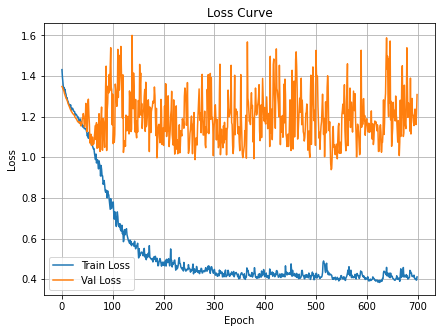

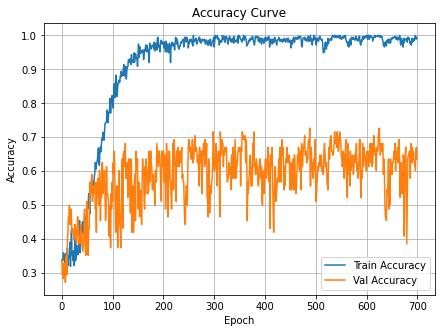

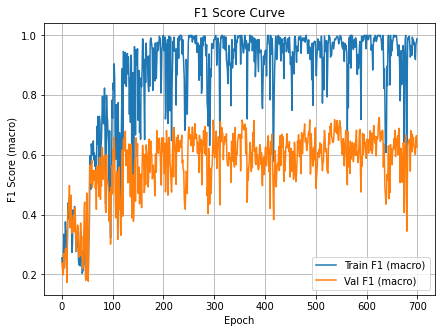

In [23]:
import matplotlib.pyplot as plt

# ================================
#  LOSS PLOT
# ================================
plt.figure(figsize=(7,5))
plt.plot(history.history.get('loss', []), label='Train Loss')
plt.plot(history.history.get('val_loss', []), label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# ================================
#  ACCURACY PLOT
# ================================
plt.figure(figsize=(7,5))
plt.plot(history.history.get('accuracy', []), label='Train Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# ================================
#  F1-SCORE PLOT  (From your callback)
# ================================
plt.figure(figsize=(7,5))
plt.plot(f1_callback.train_f1s, label='Train F1 (macro)')
plt.plot(f1_callback.val_f1s, label='Val F1 (macro)')
plt.title("F1 Score Curve")
plt.xlabel("Epoch")
plt.ylabel("F1 Score (macro)")
plt.legend()
plt.grid(True)
plt.show()


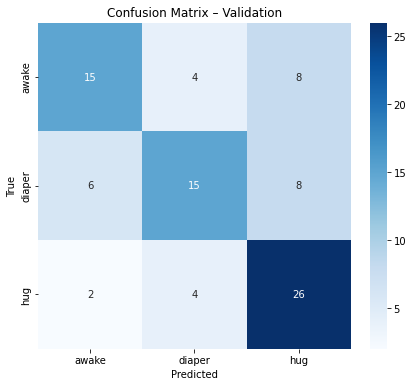

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val_split, val_preds)
labels = np.unique(y_val_split)
tick_labels = [id2cls_chinese[i] for i in labels]   # adjust mapping if not Chinese set

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Validation")
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


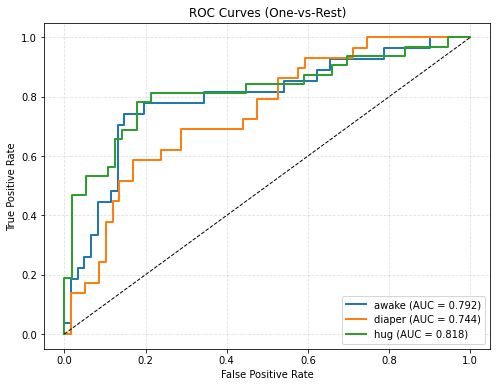

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true_onehot, y_pred_prob, class_names):
    plt.figure(figsize=(8, 6))

    n_classes = y_true_onehot.shape[1]

    for c in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, c], y_pred_prob[:, c])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2,
                 label=f"{class_names[c]} (AUC = {roc_auc:.3f})")

    # Diagonal line
    plt.plot([0, 1], [0, 1], "k--", lw=1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (One-vs-Rest)")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()

y_pred_prob = model.predict(X_val_split)
y_true_onehot = y_val_onehot

class_names = list(le.classes_)   # <-- FIXED

plot_roc_curves(y_true_onehot, y_pred_prob, class_names)




In [26]:
from sklearn.metrics import (
    f1_score, matthews_corrcoef, roc_auc_score,
    accuracy_score, precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize

f1_micro = f1_score(y_val_split, val_preds, average='micro')
f1_macro = f1_score(y_val_split, val_preds, average='macro')
mcc = matthews_corrcoef(y_val_split, val_preds)
acc = accuracy_score(y_val_split, val_preds)

# ---- ROC-AUC (One-vs-Rest) ----
y_val_bin = label_binarize(y_val_split, classes=labels)

try:
    roc_auc = roc_auc_score(
        y_val_bin, val_probs, multi_class="ovr", average="macro"
    )
except:
    roc_auc = None

print("\n===== Validation Metrics =====")
print(f"Accuracy   : {acc:.4f}")
print(f"F1-micro   : {f1_micro:.4f}")
print(f"F1-macro   : {f1_macro:.4f}")
print(f"MCC        : {mcc:.4f}")
print(f"ROC-AUC    : {roc_auc:.4f}" if roc_auc is not None else "ROC-AUC: unavailable")



===== Validation Metrics =====
Accuracy   : 0.6364
F1-micro   : 0.6364
F1-macro   : 0.6265
MCC        : 0.4560
ROC-AUC    : 0.7846


## Plot and save

In [27]:
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, matthews_corrcoef, classification_report
from sklearn.preprocessing import label_binarize

# -------------------- Setup --------------------
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Classes of interest in original encoding
keep_classes = [1, 4, 5]   # diaper=1, sleepy=4, uncomfortable=5
class_names = {1: "diaper", 4: "sleepy", 5: "uncomfortable"}

# Map to new encoded ids {0,1,2}
unique_classes = sorted(keep_classes)  # [1,4,5]
class2newid = {old: new for new, old in enumerate(unique_classes)}
id2cls_merge_3mood = {new: class_names[old] for old, new in class2newid.items()}

# -------------------- Predictions --------------------
val_probs_full = model.predict(X_val_split)

# Keep only probs for classes of interest
val_probs = val_probs_full[:, unique_classes]  # shape (N, 3)

# Recompute predictions
val_preds = np.argmax(val_probs, axis=1)

# -------------------- Confusion Matrix --------------------
cm = confusion_matrix(y_val_split, val_preds)
labels = np.unique(y_val_split)
tick_labels = [id2cls_merge_3mood[i] for i in labels]

plt.figure(figsize=(16, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=tick_labels,
    yticklabels=tick_labels,
    annot_kws={"size": 16}
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

cm_path = os.path.join(output_dir, f"confusion_matrix_{timestamp}.png")
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
plt.close()

# -------------------- Metrics --------------------
f1_micro = f1_score(y_val_split, val_preds, average='micro')
f1_macro = f1_score(y_val_split, val_preds, average='macro')
mcc = matthews_corrcoef(y_val_split, val_preds)

# Binarize labels for ROC AUC
y_val_bin = label_binarize(y_val_split, classes=np.unique(y_val_split))
try:
    roc_auc = roc_auc_score(y_val_bin, val_probs, average="macro", multi_class="ovr")
except ValueError:
    roc_auc = None

report = classification_report(
    y_val_split,
    val_preds,
    target_names=[id2cls_merge_3mood[i] for i in np.unique(y_val_split)],
    digits=4
)

stats_path = os.path.join(output_dir, f"validation_stats_{timestamp}.txt")
with open(stats_path, "w") as f:
    f.write("Validation Metrics:\n")
    f.write(f"F1 (micro): {f1_micro:.4f}\n")
    f.write(f"F1 (macro): {f1_macro:.4f}\n")
    f.write(f"MCC       : {mcc:.4f}\n")
    f.write(f"ROC AUC   : {roc_auc:.4f}\n" if roc_auc is not None else "ROC AUC not available\n")
    f.write("\nClassification Report:\n")
    f.write(report)

print(f"✅ Saved confusion matrix to {cm_path}")
print(f"✅ Saved metrics to {stats_path}")

# -------------------- Training Curves --------------------
plt.figure(figsize=(24, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
curve_path = os.path.join(output_dir, f"training_curves_{timestamp}.png")
plt.savefig(curve_path, dpi=300, bbox_inches="tight")
plt.close()

print(f"✅ Saved training curves to {curve_path}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


IndexError: index 4 is out of bounds for axis 1 with size 3

In [28]:
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    classification_report
)
from sklearn.preprocessing import label_binarize

# -------------------- Setup --------------------
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Classes of interest in original encoding
keep_classes = [1, 4, 5]   # diaper=1, sleepy=4, uncomfortable=5
class_names = {1: "diaper", 4: "sleepy", 5: "uncomfortable"}

# Map old IDs -> new {0,1,2}
unique_classes = sorted(keep_classes)  # [1,4,5]
class2newid = {old: new for new, old in enumerate(unique_classes)}
id2cls_merge_3mood = {new: class_names[old] for old, new in class2newid.items()}

# -------------------- Predictions --------------------
val_probs_full = model.predict(X_val_split)     # shape (N, all_classes)

# Keep only columns for the 3 moods
val_probs = val_probs_full[:, unique_classes]   # shape (N, 3)

# Recompute predictions
val_preds = np.argmax(val_probs, axis=1)

# -------------------- Confusion Matrix --------------------
cm = confusion_matrix(y_val_split, val_preds)
labels = np.unique(y_val_split)
tick_labels = [id2cls_merge_3mood[i] for i in labels]

plt.figure(figsize=(16, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=tick_labels,
    yticklabels=tick_labels,
    annot_kws={"size": 16}
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

cm_path = os.path.join(output_dir, f"confusion_matrix_{timestamp}.png")
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
plt.close()

# -------------------- Metrics --------------------
f1_micro = f1_score(y_val_split, val_preds, average='micro')
f1_macro = f1_score(y_val_split, val_preds, average='macro')
mcc = matthews_corrcoef(y_val_split, val_preds)

# Binarize labels for ROC AUC (3 classes only)
y_val_bin = label_binarize(y_val_split, classes=np.arange(len(unique_classes)))

try:
    roc_auc = roc_auc_score(y_val_bin, val_probs, average="macro", multi_class="ovr")
except ValueError:
    roc_auc = None

report = classification_report(
    y_val_split,
    val_preds,
    target_names=[id2cls_merge_3mood[i] for i in np.unique(y_val_split)],
    digits=4
)

stats_path = os.path.join(output_dir, f"validation_stats_{timestamp}.txt")
with open(stats_path, "w") as f:
    f.write("Validation Metrics:\n")
    f.write(f"F1 (micro): {f1_micro:.4f}\n")
    f.write(f"F1 (macro): {f1_macro:.4f}\n")
    f.write(f"MCC       : {mcc:.4f}\n")
    f.write(f"ROC AUC   : {roc_auc:.4f}\n" if roc_auc is not None else "ROC AUC not available\n")
    f.write("\nClassification Report:\n")
    f.write(report)
    f.write("\nClass mapping:\n")
    f.write(str(id2cls_merge_3mood))

print(f"✅ Saved confusion matrix to {cm_path}")
print(f"✅ Saved metrics to {stats_path}")

# -------------------- Training Curves --------------------
plt.figure(figsize=(24, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
curve_path = os.path.join(output_dir, f"training_curves_{timestamp}.png")
plt.savefig(curve_path, dpi=300, bbox_inches="tight")
plt.close()

print(f"✅ Saved training curves to {curve_path}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


IndexError: index 4 is out of bounds for axis 1 with size 3

In [30]:
import numpy as np

# Get full probability predictions (shape: [n_samples, n_classes])
val_probs = model.predict(X_val_split)
val_preds = np.argmax(val_probs, axis=1)   # top-1 predictions

# Sort predictions to get top-2 indices
top2_preds = np.argsort(val_probs, axis=1)[:, -2:]  # last two = top-2

# Boolean: was the correct label in top-2 predictions?
correct_top2 = [y_val_split[i] in top2_preds[i] for i in range(len(y_val_split))]

# Count stats
top1_correct = np.sum(val_preds == y_val_split)
top2_correct = np.sum(correct_top2)
only_second_correct = np.sum((val_preds != y_val_split) & np.array(correct_top2))

print(f"Total samples        : {len(y_val_split)}")
print(f"Top-1 correct        : {top1_correct}")
print(f"Top-2 correct        : {top2_correct}")
print(f"Wrong top-1 but fixed by 2nd : {only_second_correct}")
print(f"Top-1 Accuracy       : {top1_correct/len(y_val_split):.4f}")
print(f"Top-2 Accuracy       : {top2_correct/len(y_val_split):.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Total samples        : 88
Top-1 correct        : 65
Top-2 correct        : 79
Wrong top-1 but fixed by 2nd : 14
Top-1 Accuracy       : 0.7386
Top-2 Accuracy       : 0.8977


In [29]:
import numpy as np

# Get probability predictions
val_probs = model.predict(X_val_split)
val_preds = np.argmax(val_probs, axis=1)

# Top-2 indices per sample
top2_preds = np.argsort(val_probs, axis=1)[:, -2:]

# Identify "wrong top-1 but fixed by top-2"
wrong_fixed = (val_preds != y_val_split) & np.array(
    [y_val_split[i] in top2_preds[i] for i in range(len(y_val_split))]
)

# # Class mapping (example, update to match your dataset)
# id2cls = {
#     0: "hungry",
#     1: "awake",
#     2: "sleepy",
#     3: "diaper",
#     4: "uncomfortable"
# }

# Count per-class
counts = {cls: 0 for cls in id2cls_chinese.values()}
for i, flag in enumerate(wrong_fixed):
    if flag:  # case where top-2 fixed it
        cls_name = id2cls_chinese[y_val_split[i]]
        counts[cls_name] += 1

print("Wrong top-1 but correct at 2nd prediction (per class):")
for cls, c in counts.items():
    print(f"{cls:15s}: {c}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Wrong top-1 but correct at 2nd prediction (per class):
awake          : 11
diaper         : 6
hug            : 4
hungry         : 0
sleepy         : 0
uncomfortable  : 0


In [30]:
import numpy as np

# Get probability predictions
val_probs = model.predict(X_val_split)
val_preds = np.argmax(val_probs, axis=1)

# Top-2 indices per sample
top2_preds = np.argsort(val_probs, axis=1)[:, -2:]

# Identify "wrong top-1 but fixed by top-2"
wrong_fixed = (val_preds != y_val_split) & np.array(
    [y_val_split[i] in top2_preds[i] for i in range(len(y_val_split))]
)


# Count per true class and record wrong top-1s
counts = {cls: 0 for cls in id2cls_chinese.values()}
confusions = {cls: [] for cls in id2cls_chinese.values()}

for i, flag in enumerate(wrong_fixed):
    if flag:
        true_cls = id2cls_chinese[y_val_split[i]]
        wrong_cls = id2cls_chinese[val_preds[i]]
        counts[true_cls] += 1
        confusions[true_cls].append(wrong_cls)

# Print summary
print("Wrong top-1 but correct at 2nd prediction (per class):")
for cls, c in counts.items():
    if c > 0:
        wrong_breakdown = {w: confusions[cls].count(w) for w in set(confusions[cls])}
        print(f"{cls:15s}: {c} cases")
        for wrong, wc in wrong_breakdown.items():
            print(f"   → misclassified as {wrong}: {wc}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Wrong top-1 but correct at 2nd prediction (per class):
awake          : 11 cases
   → misclassified as hug: 8
   → misclassified as diaper: 3
diaper         : 6 cases
   → misclassified as hug: 2
   → misclassified as awake: 4
hug            : 4 cases
   → misclassified as diaper: 2
   → misclassified as awake: 2


# Avg smooth Ensemble Chinese baby cry and reverb chinese baby cry and Baby2020

# Agree vote Ensemble Chinese baby cry and reverb chinese baby cry and Baby2020

# Statistical test analysis of ensemble merged and single trainer